## Signate　債務不履行リスクの低減

https://signate.jp/competitions/743

概要  
・目的変数は、貸し倒れたかどうか（ChargedOffを1、FullyPaidを0）  
・予測精度の評価は、F1Score

（最終提出ファイル）  
・LightGBMモデルを作成    
・初期の特徴量にmiddle gradeの人達に対する利子率の適正を測るような特徴量を２つ追加して最終予測値を算出

最終スコア：0.3923  
最終順位：246人参加中、7位

##  

## 準備

In [39]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import japanize_matplotlib
import matplotlib.pyplot as plt

from sklearn import metrics
from scipy.stats import rankdata
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## データの確認
・貸し倒れと利子率が最も相関関係にある  
・貸し倒れは全体の20%弱

In [476]:
df = pd.read_csv('train.csv')
df

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,0,609.296068,3 years,8.421982,A5,0 years,debt_consolidation,714.061803,Individual,FullyPaid
1,1,1183.266999,5 years,10.286776,B1,10 years,credit_card,697.706701,Individual,ChargedOff
2,2,695.783256,3 years,14.723425,C2,1 year,debt_consolidation,656.419357,Individual,FullyPaid
3,3,738.392546,3 years,14.260708,C1,0 years,credit_card,657.906852,Individual,FullyPaid
4,4,1642.400654,5 years,25.217452,E5,10 years,debt_consolidation,662.972297,Individual,FullyPaid
...,...,...,...,...,...,...,...,...,...,...
242145,242145,2427.939262,3 years,13.673803,B4,8 years,debt_consolidation,657.206417,Individual,FullyPaid
242146,242146,1224.346665,3 years,11.793595,B3,10 years,debt_consolidation,699.763028,Individual,ChargedOff
242147,242147,2089.513458,3 years,8.218123,A4,1 year,other,724.556339,Individual,FullyPaid
242148,242148,3459.367114,3 years,14.875958,C2,9 years,debt_consolidation,688.249378,Individual,FullyPaid


In [477]:
df.isnull().sum()

id                   0
loan_amnt            0
term                 0
interest_rate        0
grade                0
employment_length    0
purpose              0
credit_score         0
application_type     0
loan_status          0
dtype: int64

In [478]:
df.duplicated().unique()

array([False])

In [5]:
df.describe()

,id,loan_amnt,interest_rate,credit_score
count,242150.00000,242150.000000,242150.000000,242150.000000
mean,121074.50000,1520.389009,13.801496,683.575024
std,69902.82818,830.250197,4.588924,29.554795
min,0.00000,323.797279,5.704849,655.424269
25%,60537.25000,761.954545,10.876086,659.531106
50%,121074.50000,1212.680586,13.543833,678.672563
75%,181611.75000,2152.213330,17.172395,698.591960
max,242149.00000,3851.867974,27.980604,808.551641


In [6]:
df.term.value_counts()

3 years    189887
5 years     52263
Name: term, dtype: int64

In [7]:
df.term = df.term.replace({"3 years":3, "5 years":5})
df.term.value_counts()

3    189887
5     52263
Name: term, dtype: int64

In [8]:
df.grade.value_counts()

C4    18936
B4    18409
C1    16767
B2    16357
B3    16058
B1    15484
B5    15163
C2    13917
C5    11420
A5    10785
D1    10464
C3    10266
D4     9828
A4     9441
D2     8823
D3     8387
D5     6866
A3     6532
A1     5764
A2     5749
E2     2835
E4     2301
E1      640
E5      535
E3      416
F5        4
F3        3
Name: grade, dtype: int64

In [9]:
df.employment_length.value_counts()

10 years    103339
0 years      19373
9 years      18374
2 years      15783
1 year       15141
6 years      14815
4 years      13418
5 years      12812
7 years      12673
3 years      11295
8 years       5127
Name: employment_length, dtype: int64

In [10]:
employment_list = {'0 years':0, '10 years':10, '1 year':1, '2 years':2, '3 years':3, '6 years':6,
       '9 years':9, '7 years':7, '4 years':4, '5 years':5, '8 years':8}

df.employment_length = df.employment_length.replace(employment_list)
df.employment_length.value_counts()

10    103339
0      19373
9      18374
2      15783
1      15141
6      14815
4      13418
5      12812
7      12673
3      11295
8       5127
Name: employment_length, dtype: int64

In [11]:
df.purpose.value_counts()

debt_consolidation    160207
credit_card            48900
other                  17633
home_improvement        7686
car                     3855
medical                 3154
small_business           449
major_purchase           262
house                      4
Name: purpose, dtype: int64

In [12]:
df.application_type.value_counts()

Individual    240368
Joint App       1782
Name: application_type, dtype: int64

In [13]:
df.application_type = df.application_type.replace({"Individual":1, "Joint App":0}).astype(int)

In [14]:
df.employment_length.unique()

array([ 0, 10,  1,  2,  3,  6,  9,  7,  4,  5,  8], dtype=int64)

In [15]:
df.loan_status.value_counts()

FullyPaid     199794
ChargedOff     42356
Name: loan_status, dtype: int64

In [16]:
df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})
df

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,0,609.296068,3,8.421982,A5,0,debt_consolidation,714.061803,1,0
1,1,1183.266999,5,10.286776,B1,10,credit_card,697.706701,1,1
2,2,695.783256,3,14.723425,C2,1,debt_consolidation,656.419357,1,0
3,3,738.392546,3,14.260708,C1,0,credit_card,657.906852,1,0
4,4,1642.400654,5,25.217452,E5,10,debt_consolidation,662.972297,1,0
...,...,...,...,...,...,...,...,...,...,...
242145,242145,2427.939262,3,13.673803,B4,8,debt_consolidation,657.206417,1,0
242146,242146,1224.346665,3,11.793595,B3,10,debt_consolidation,699.763028,1,1
242147,242147,2089.513458,3,8.218123,A4,1,other,724.556339,1,0
242148,242148,3459.367114,3,14.875958,C2,9,debt_consolidation,688.249378,1,0


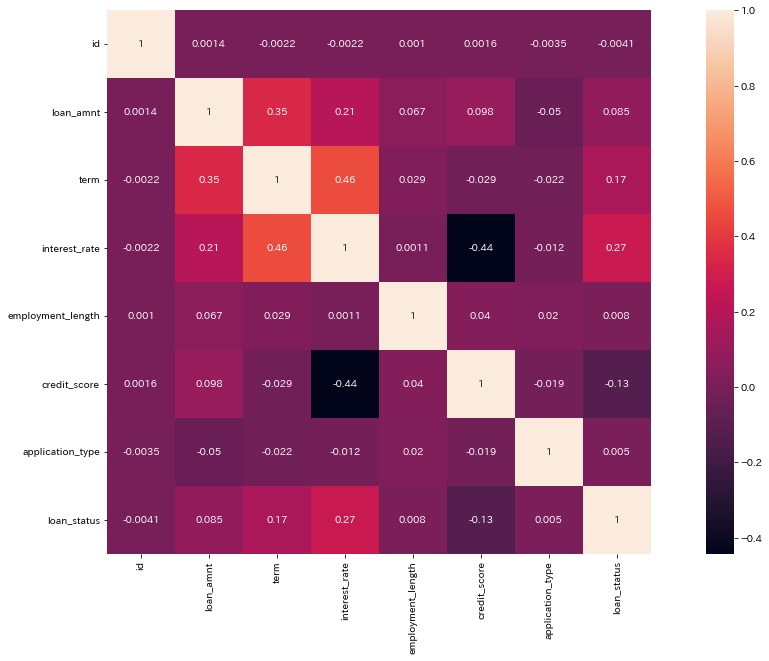

In [17]:
plt.figure(figsize = (20,10))
sns.heatmap(df.corr(), square=True, annot=True)
plt.show()

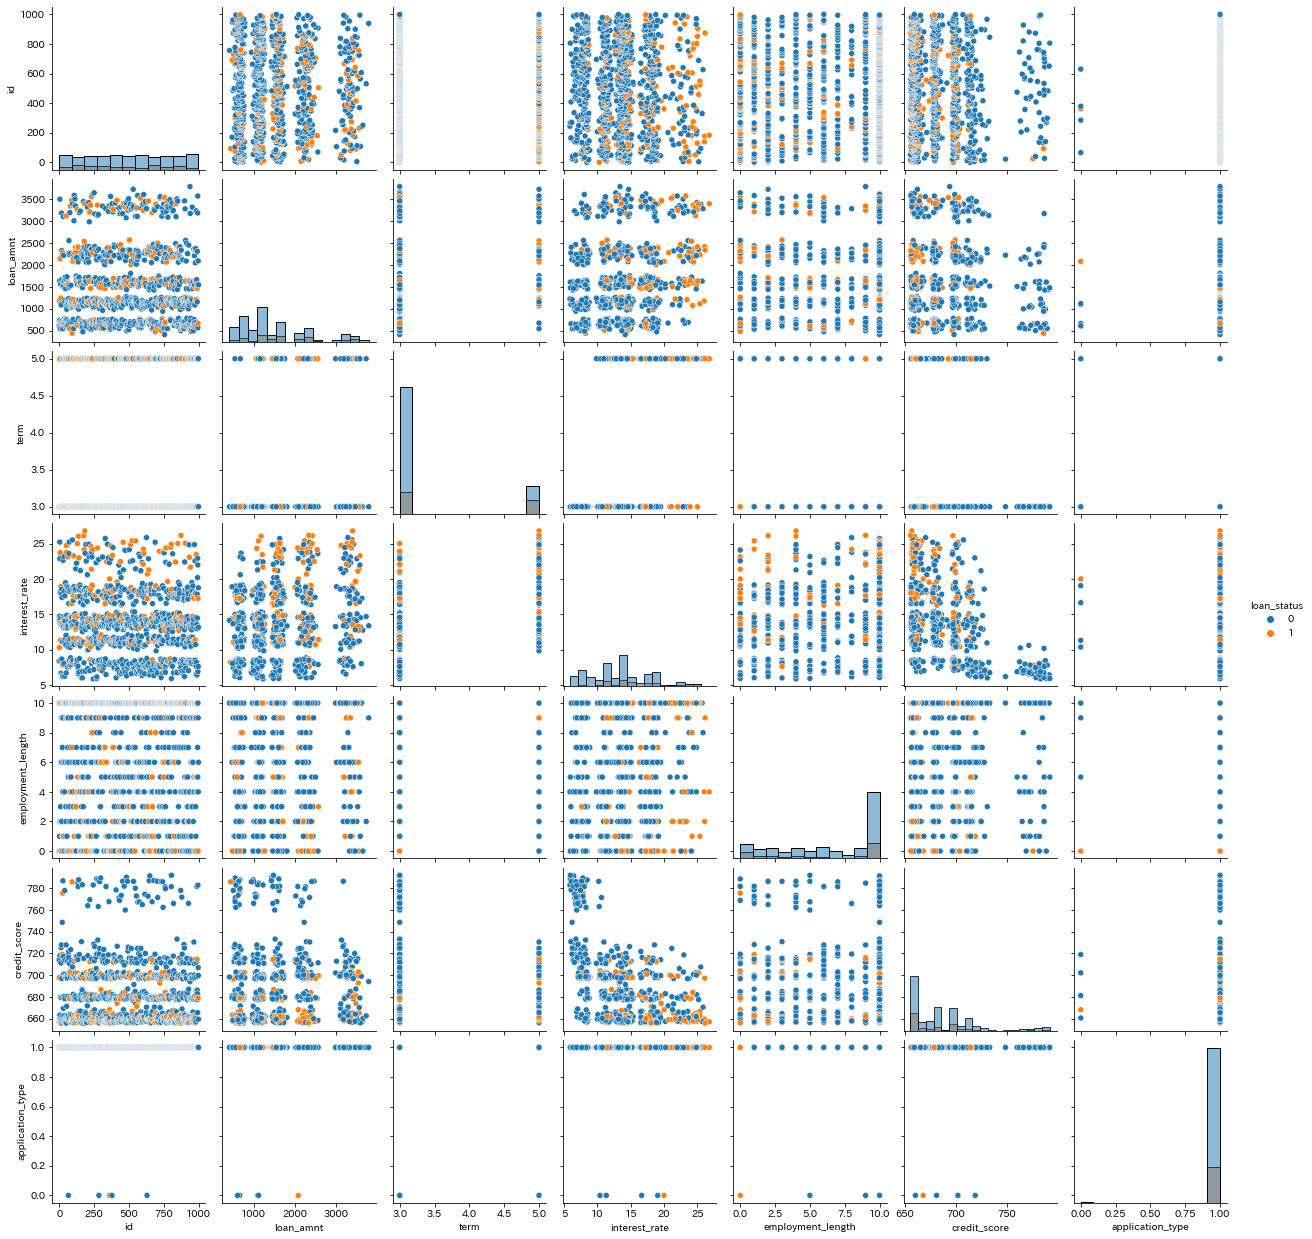

In [19]:
sns.pairplot(df[:1000], hue='loan_status', diag_kind ='hist')

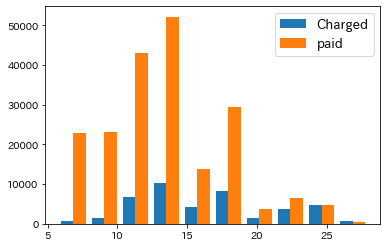

In [57]:
# データ準備
dataset1=df[df['loan_status']==1]['interest_rate']
dataset2=df[df['loan_status']==0]['interest_rate']

# グラフの描画
plt.hist([dataset1, dataset2], alpha=1, label=["Charged", "paid"])
plt.legend(loc="best", fontsize=13) 

In [ ]:
df = pd.get_dummies(df, columns=["grade", "purpose"])

In [20]:
df.shape

(242150, 10)

In [223]:
df.corr()

,id,loan_amnt,term,interest_rate,employment_length,credit_score,application_type,loan_status,grade_A1,grade_A2,grade_A3,grade_A4,grade_A5,grade_B1,grade_B2,grade_B3,grade_B4,grade_B5,grade_C1,grade_C2,grade_C3,grade_C4,grade_C5,grade_D1,grade_D2,grade_D3,grade_D4,grade_D5,grade_E1,grade_E2,grade_E3,grade_E4,grade_E5,grade_F3,grade_F5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_other,purpose_small_business
id,1.000000,0.001381,-0.002166,-0.002235,0.001016,0.001604,-0.003517,-0.004058,0.000662,-0.000606,-0.001042,0.001841,0.001943,0.003122,-0.000172,-0.002666,0.000534,-0.004272,-0.001205,-0.001922,-0.001203,0.002096,0.001665,-0.001844,0.002032,0.001055,0.000109,0.000020,-0.005083,0.002218,0.003309,-0.000827,0.001167,0.000229,0.001360,0.002659,-0.001536,0.000090,0.001394,0.000552,-0.000502,-0.001264,0.000688,-0.000560
loan_amnt,0.001381,1.000000,0.345419,0.210790,0.066738,0.098274,-0.050376,0.085033,0.000273,-0.031547,0.065800,-0.018031,-0.036633,-0.045920,-0.000438,-0.023365,-0.069456,-0.029521,-0.061782,-0.086156,0.028837,0.018440,0.039730,-0.004848,0.041077,0.033839,0.091464,0.116226,0.021970,0.048853,0.017949,0.061551,0.023028,-0.000186,0.000813,-0.103549,-0.002875,0.092768,0.004847,-0.002180,0.005769,-0.051178,-0.100436,0.025324
term,-0.002166,0.345419,1.000000,0.464065,0.029251,-0.029139,-0.022479,0.167006,-0.066513,-0.050098,0.082544,-0.082178,-0.102028,-0.070486,-0.064729,-0.065748,-0.084128,-0.065365,-0.060253,-0.027288,0.110416,0.023370,0.059345,0.015924,0.033362,0.040341,0.135255,0.194199,0.043183,0.113116,0.057985,0.138274,0.081570,0.006709,0.007747,-0.053174,-0.022205,0.063575,-0.015281,-0.002132,0.023344,-0.004668,-0.049091,0.016122
interest_rate,-0.002235,0.210790,0.464065,1.000000,0.001107,-0.443101,-0.012265,0.270212,-0.237141,-0.175278,0.018433,-0.224963,-0.257688,-0.209769,-0.135354,-0.124059,-0.091375,-0.067256,-0.020003,0.014647,0.047797,0.088884,0.106799,0.178293,0.180089,0.210970,0.258729,0.266069,0.092130,0.208438,0.078542,0.202678,0.102909,0.008568,0.009121,-0.003045,-0.091666,0.067235,-0.047947,0.002263,0.045034,0.054621,0.017987,0.032922
employment_length,0.001016,0.066738,0.029251,0.001107,1.000000,0.040481,0.020042,0.008040,0.003732,0.010694,0.034196,0.011782,0.015470,0.054700,-0.010581,-0.003198,-0.020545,-0.013534,-0.052187,-0.045537,-0.003546,0.014380,0.007619,-0.009062,0.015465,0.002732,0.000914,0.005116,-0.002843,-0.003044,0.001481,0.021148,0.009988,-0.003213,-0.002970,-0.006168,0.007399,-0.012652,0.009807,-0.000747,-0.009450,-0.011596,0.013985,0.001473
credit_score,0.001604,0.098274,-0.029139,-0.443101,0.040481,1.000000,-0.019169,-0.126770,0.346731,0.200150,0.165217,0.181626,0.149318,0.026462,0.038598,0.015175,-0.062663,-0.037453,-0.090222,-0.109732,-0.029407,-0.069675,-0.064927,-0.094961,-0.091258,-0.083931,-0.065217,-0.030671,-0.026983,-0.049616,-0.017017,-0.052351,-0.026118,-0.001771,-0.003435,0.011013,0.019943,-0.048911,0.087015,0.002283,-0.018121,-0.007357,-0.000484,0.001167
application_type,-0.003517,-0.050376,-0.022479,-0.012265,0.020042,-0.019169,1.000000,0.005049,-0.005573,0.000098,-0.000874,-0.001628,0.008987,0.008285,-0.013020,-0.005986,0.006832,0.008892,-0.001829,0.012335,-0.000348,0.003483,0.004796,0.006655,0.009523,-0.002452,-0.022692,-0.025463,0.001609,0.001735,0.001238,-0.005512,0.003023,0.000303,0.000350,0.002073,-0.013858,0.008882,-0.006184,0.000350,-0.000106,-0.001189,0.008696,0.001465
loan_status,-0.004058,0.085033,0.167006,0.270212,0.008040,-0.126770,0.005049,1.000000,-0.061914,-0.049025,0.038142,-0.063538,-0.078436,-0.043162,-0.007498,-0.053289,-0.039581,0.013359,-0.014551,-0.007488,0.014476,0.047606,0.057765,0.016288,0.035141,0.043634,0.048914,0.071519,0.006998,0.045387,-0.003876,0.030984,0.045013,0.004556,0.008827,-0.016354,-0.044636,0.043655,-0.023092,-0.001871,0.026840,0.029272,-0.003527,0.001886
grade_A1,0.000662,0.000273,-0.066513,-0.237141,0.003732,0.346731,-0.005573,

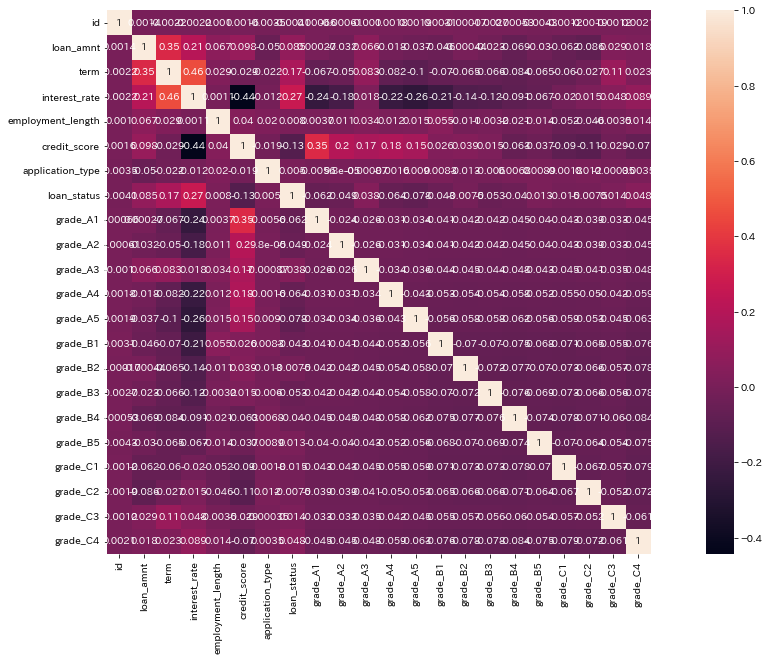

In [200]:
plt.figure(figsize = (20,10))
sns.heatmap(df.iloc[:,:22].corr(), square=True, annot=True)
plt.show()

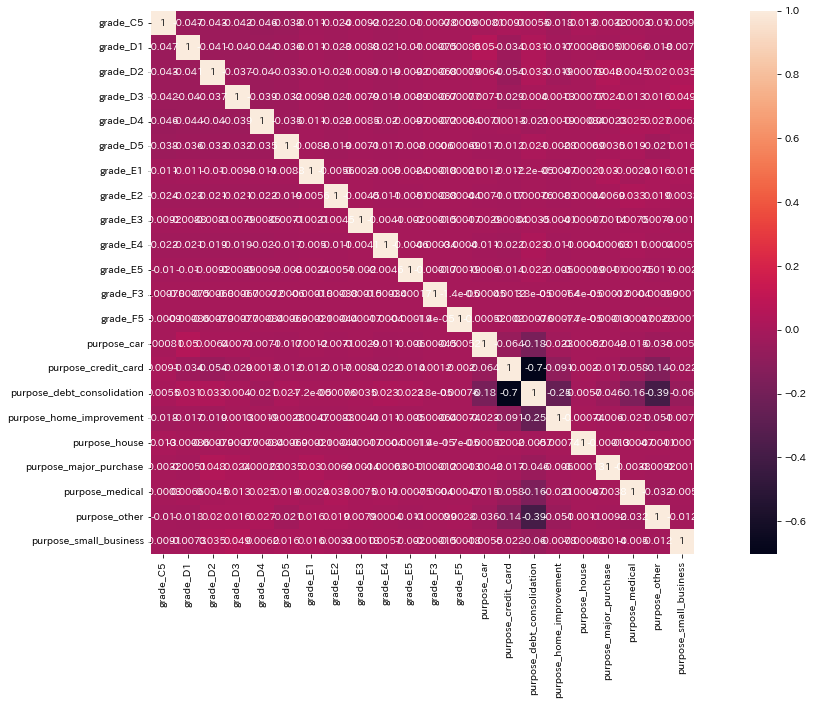

In [67]:
plt.figure(figsize = (20,10))
sns.heatmap(df.iloc[:,22:].corr(), square=True, annot=True)
plt.show()

## 前処理(Train&Test)
・trainにあってtestにないカテゴリデータなどもあったため、事前にマージした上で処理

In [67]:
#まとめて
df = pd.read_csv('train.csv')
df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})

test = pd.read_csv('test.csv')
test.loan_status = 2

df = pd.concat([df, test], axis=0)

employment_list = {'0 years':0, '10 years':10, '1 year':1, '2 years':2, '3 years':3, '6 years':6,
                   '9 years':9, '7 years':7, '4 years':4, '5 years':5, '8 years':8}

df.term = df.term.replace({"3 years":3, "5 years":5})
df.employment_length = df.employment_length.replace(employment_list)
df.application_type = df.application_type.replace({"Individual":1, "Joint App":0}).astype(int)
df = pd.get_dummies(df, columns=["grade", "purpose"])

In [458]:
# test = pd.read_csv('test.csv')
# test.loan_status = 2
# test

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type
0,242150,1161.830205,3 years,13.105362,C1,10 years,credit_card,682.016083,Individual
1,242151,2257.465815,5 years,14.196200,C5,10 years,debt_consolidation,668.240313,Individual
2,242152,2182.137002,3 years,8.307772,A5,10 years,credit_card,703.277694,Individual
3,242153,520.284912,3 years,6.956504,A2,7 years,debt_consolidation,731.138779,Individual
4,242154,2303.349549,3 years,11.658497,B3,6 years,debt_consolidation,698.368991,Individual
...,...,...,...,...,...,...,...,...,...
26895,269045,1169.767130,3 years,13.609916,B4,1 year,credit_card,656.939828,Individual
26896,269046,2235.153322,3 years,7.248690,A2,10 years,credit_card,765.770393,Individual
26897,269047,3272.971410,3 years,9.957002,B4,6 years,debt_consolidation,793.887391,Individual
26898,269048,1607.397707,3 years,10.892554,B3,10 years,debt_consolidation,658.815541,Individual


In [459]:
# df = pd.read_csv('train.csv')
# df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})
# len(df)

242150

In [460]:
# df = pd.concat([df, test], axis=0)
# df

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,0,609.296068,3 years,8.421982,A5,0 years,debt_consolidation,714.061803,Individual,0.0
1,1,1183.266999,5 years,10.286776,B1,10 years,credit_card,697.706701,Individual,1.0
2,2,695.783256,3 years,14.723425,C2,1 year,debt_consolidation,656.419357,Individual,0.0
3,3,738.392546,3 years,14.260708,C1,0 years,credit_card,657.906852,Individual,0.0
4,4,1642.400654,5 years,25.217452,E5,10 years,debt_consolidation,662.972297,Individual,0.0
...,...,...,...,...,...,...,...,...,...,...
26895,269045,1169.767130,3 years,13.609916,B4,1 year,credit_card,656.939828,Individual,NaN
26896,269046,2235.153322,3 years,7.248690,A2,10 years,credit_card,765.770393,Individual,NaN
26897,269047,3272.971410,3 years,9.957002,B4,6 years,debt_consolidation,793.887391,Individual,NaN
26898,269048,1607.397707,3 years,10.892554,B3,10 years,debt_consolidation,658.815541,Individual,NaN


In [461]:
# employment_list = {'0 years':0, '10 years':10, '1 year':1, '2 years':2, '3 years':3, '6 years':6,
#                    '9 years':9, '7 years':7, '4 years':4, '5 years':5, '8 years':8}

# df.term = df.term.replace({"3 years":3, "5 years":5})
# df.employment_length = df.employment_length.replace(employment_list)
# df.application_type = df.application_type.replace({"Individual":1, "Joint App":0}).astype(int)
# df = pd.get_dummies(df, columns=["grade", "purpose"])
# df

,id,loan_amnt,term,interest_rate,employment_length,credit_score,application_type,loan_status,grade_A1,grade_A2,grade_A3,grade_A4,grade_A5,grade_B1,grade_B2,grade_B3,grade_B4,grade_B5,grade_C1,grade_C2,grade_C3,grade_C4,grade_C5,grade_D1,grade_D2,grade_D3,grade_D4,grade_D5,grade_E1,grade_E2,grade_E3,grade_E4,grade_E5,grade_F3,grade_F5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business
0,0,609.296068,3,8.421982,0,714.061803,1,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,1183.266999,5,10.286776,10,697.706701,1,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2,695.783256,3,14.723425,1,656.419357,1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,3,738.392546,3,14.260708,0,657.906852,1,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,4,1642.400654,5,25.217452,10,662.972297,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26895,269045,1169.767130,3,13.609916,1,656.939828,1,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
26896,269046,2235.153322,3,7.248690,10,765.770393,1,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
26897,269047,3272.971410,3,9.957002,6,793.887391,1,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
26898,269048,1607.397707,3,10.892554,10,658.815541,1,NaN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [462]:
# # get_dummyでデータ量が問題なければそれに越したことはなかった
# grade_list = {"A1":1,"A2":2,"A3":3,"A4":4,"A5":5,
#               "B1":6,"B2":7,"B3":8,"B4":9,"B5":10,
#               "C1":11,"C2":12,"C3":13,"C4":14,"C5":15,
#               "D1":16,"D2":17,"D3":18,"D4":19,"D5":20,
#               "E1":21,"E2":22,"E3":23,"E4":24,"E5":25,
#               "F1":26,"F2":27,"F3":28,"F4":29,"F5":30}

# df.grade = df.grade.replace(grade_list).astype('int')

In [463]:
# https://qiita.com/k8m/items/bcb679d907d3e19e0c5a

## モデル構築
・LGBM、ロジスティック回帰、ランダムフォレスト、ニューラルネットワーク

#### LGBM

In [40]:
#前処理
df = pd.read_csv('train.csv')
df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})

test = pd.read_csv('test.csv')
test.loan_status = 2

df = pd.concat([df, test], axis=0)

employment_list = {'0 years':0, '10 years':10, '1 year':1, '2 years':2, '3 years':3, '6 years':6,
                   '9 years':9, '7 years':7, '4 years':4, '5 years':5, '8 years':8}

df.term = df.term.replace({"3 years":3, "5 years":5})
df.employment_length = df.employment_length.replace(employment_list)
df.application_type = df.application_type.replace({"Individual":1, "Joint App":0}).astype(int)
df = pd.get_dummies(df, columns=["grade", "purpose"])

In [41]:
#追加した特徴量
m_grade = df.grade_B1 + df.grade_B2 + df.grade_B3 + df.grade_B4 + df.grade_B5 + df.grade_C1 + df.grade_C2

df['Availability'] = df.loan_amnt * df.term * df.interest_rate / df.employment_length * m_grade
df['Assesment'] = df.interest_rate / df.credit_score * m_grade

In [42]:
# 目的変数と説明変数の生成
train = df[:242150]
test = df[242150:]

x = train.drop('loan_status', axis=1)
y = train['loan_status']

x.shape, y.shape

((242150, 46), (242150,))

In [43]:
#学習・テストデータへの分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle = True)

In [62]:
#モデル構築
trains = lgb.Dataset(x_train, y_train)
valids = lgb.Dataset(x_test, y_test)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': -1,
    'subsample_freq': 1,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round":20000,
    "early_stopping_rounds": 100,
    'num_leaves': 30,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.9,
    'is_unbalance': True,
}

model = lgb.train(params, trains, valid_sets = [trains, valids], keep_training_booster = True, verbose_eval =300)

C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.721154	valid_1's auc: 0.717489
[600]	training's auc: 0.728242	valid_1's auc: 0.720192
[900]	training's auc: 0.734399	valid_1's auc: 0.72087
[1200]	training's auc: 0.740317	valid_1's auc: 0.721229
[1500]	training's auc: 0.745668	valid_1's auc: 0.72134
Early stopping, best iteration is:
[1431]	training's auc: 0.744423	valid_1's auc: 0.721404


In [63]:
#予測値の計算
y_pred = model.predict(x_test, num_iteration=model.best_iteration)
y_pred[:5]

array([0.57068063, 0.55248754, 0.64571033, 0.46947024, 0.16415566])

In [101]:
#AUCの計算
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)

0.7214035160655509


In [47]:
#ベンチマーク：オリジナルpara、2columnがカテゴリのデフォルトモデル
#0.7213441573918782

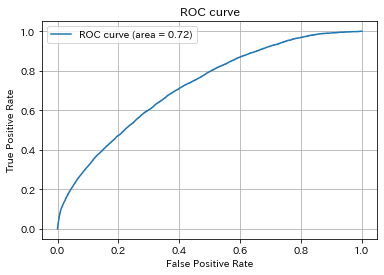

In [79]:
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [80]:
y_pred = np.where(y_pred < 0.5, 0, 1)

0.3989392843613321


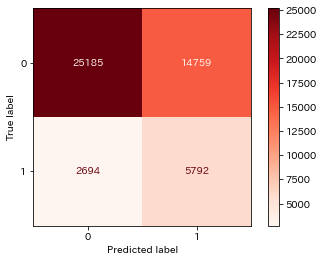

In [81]:
# 混同行列を表示
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

#F1スコアの計算
f1 = f1_score(y_test, y_pred)
print(f1)

0.3989392843613321


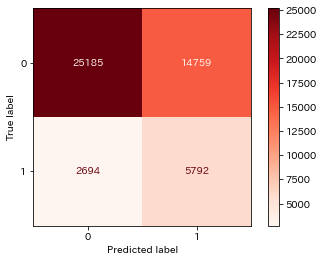

In [490]:
# 混同行列を表示
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

#F1スコアの計算
f1 = f1_score(y_test, y_pred)
print(f1)

In [491]:
#ベンチマーク：オリジナルpara、2columnがカテゴリのデフォルト
#0.39626413013509787

In [524]:
#特徴量の寄与率
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=x_train.columns, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
display(importance[:20])

,importance
pred_loan_status,947974.195801
interest_rate,530977.856859
term,81698.291468
credit_score,76674.058493
Assesment,58925.252460
sum4,39320.250299
Availability,35281.074686
sum1,17426.615129
sum2,17374.065767
grade_A5,15345.204367


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

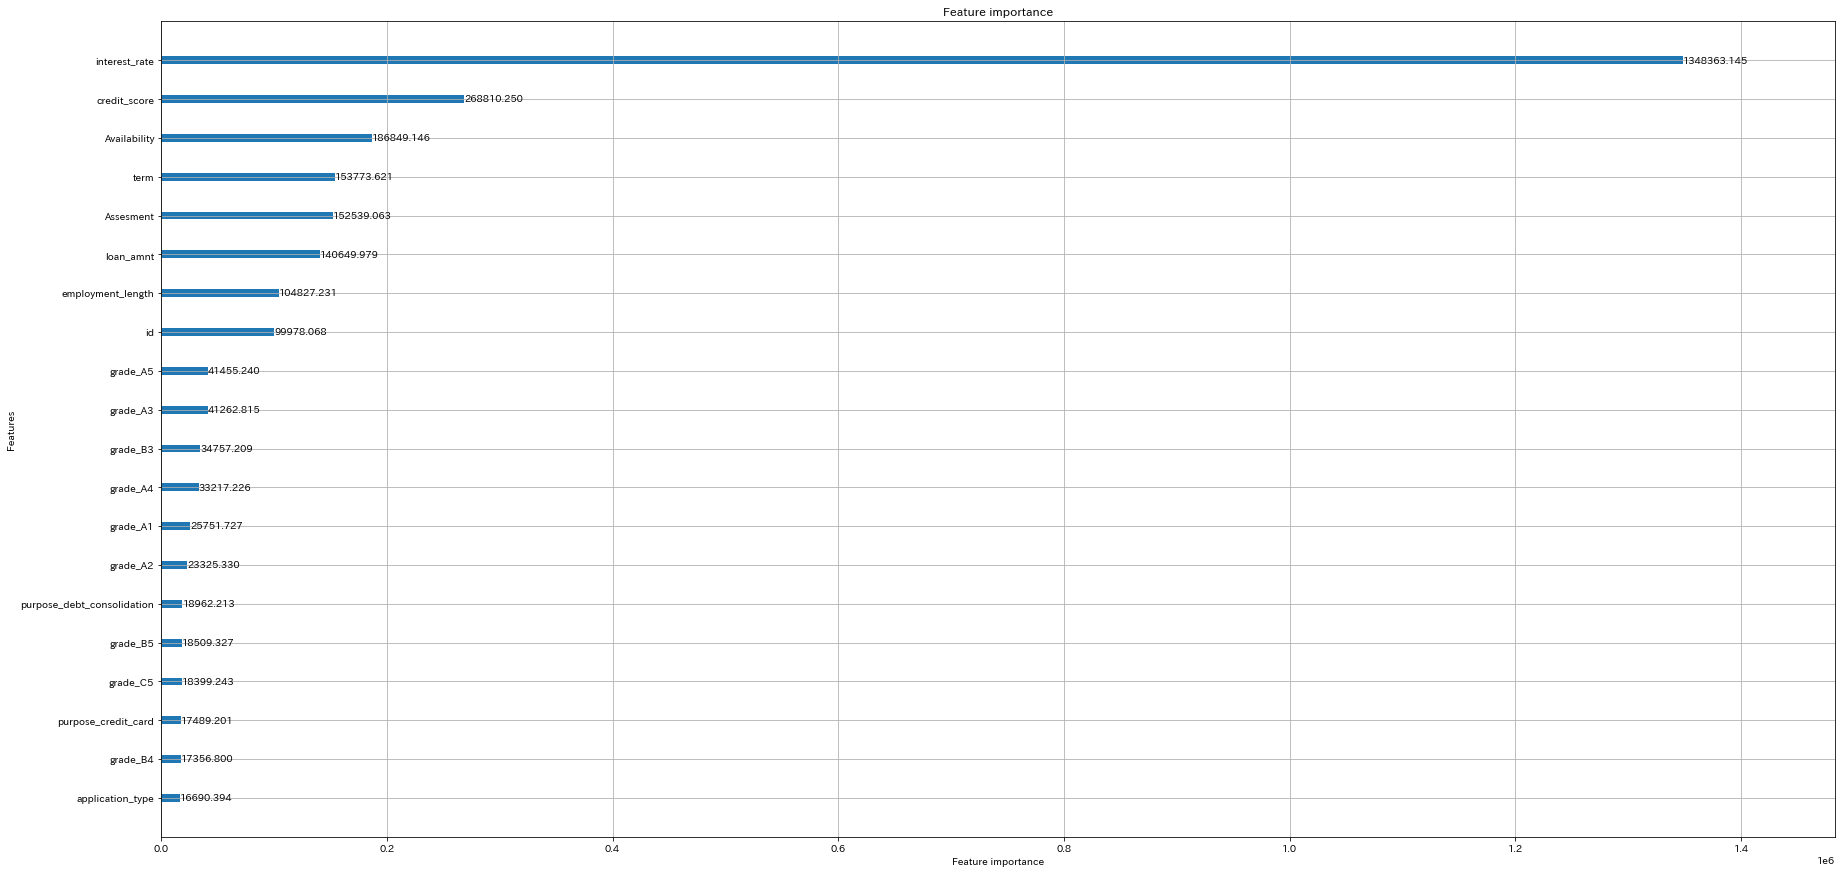

In [493]:
#特徴量重要度の可視化
lgb.plot_importance(model, figsize=(30,15), max_num_features=20, importance_type='gain')

#### LGBM Classifier(sklearn API)

In [82]:
#モデル構築
clf = lgb.LGBMClassifier(boosting_type='gbdt',
                         class_weight='balanced',
                         #metric='auc',
                         learning_rate=0.01,
                         max_depth=-1,
                         min_child_samples=20,
                         num_leaves=30,
                         random_state=42,
                         subsample_freq=1,
                         n_estimators=2000,
                         feature_fraction=0.6,
                         bagging_fraction=0.9,
                         min_child_sample=30,
                         importance_type='split'
                         )

model = clf.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=100, verbose=300)

C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: min_child_sample
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[300]	valid_0's binary_logloss: 0.610552
[600]	valid_0's binary_logloss: 0.605479
[900]	valid_0's binary_logloss: 0.603315
[1200]	valid_0's binary_logloss: 0.601637
[1500]	valid_0's binary_logloss: 0.600222
[1800]	valid_0's binary_logloss: 0.598856


In [83]:
#予測値の計算
y_pred = model.predict(x_test, num_iteration = model.best_iteration_)
y_pred[:5]

array([1., 1., 1., 0., 0.])

In [84]:
#AUCの計算
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)

0.6550746197870514


In [85]:
#ベンチマーク：オリジナルpara、2columnがカテゴリのデフォルトモデル
#0.7213441573918782

0.3980373051224944


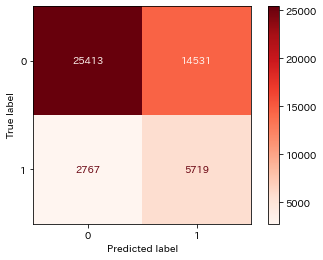

In [86]:
# 混同行列を表示
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

#F1スコアの計算
f1 = f1_score(y_test, y_pred)
print(f1)

#### ロジスティック回帰

In [87]:
#前処理
df = pd.read_csv('train.csv')
df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})

test = pd.read_csv('test.csv')
test.loan_status = 2

df = pd.concat([df, test], axis=0)

employment_list = {'0 years':0, '10 years':10, '1 year':1, '2 years':2, '3 years':3, '6 years':6,
                   '9 years':9, '7 years':7, '4 years':4, '5 years':5, '8 years':8}

df.term = df.term.replace({"3 years":3, "5 years":5})
df.employment_length = df.employment_length.replace(employment_list)
df.application_type = df.application_type.replace({"Individual":1, "Joint App":0}).astype(int)
df = pd.get_dummies(df, columns=["grade", "purpose"])

In [88]:
#追加した特徴量
m_grade = df.grade_B1 + df.grade_B2 + df.grade_B3 + df.grade_B4 + df.grade_B5 + df.grade_C1 + df.grade_C2

df['Availability'] = df.loan_amnt * df.term * df.interest_rate / df.employment_length * m_grade
df['Availability'] = df['Availability'].fillna(0)
df['Availability'] = df['Availability'].replace(np.inf, 500000)

df['Assesment'] = df.interest_rate / df.credit_score * m_grade

In [89]:
# 目的変数と説明変数の生成
train = df[:242150]
test = df[242150:]

x = train.drop('loan_status', axis=1)
y = train['loan_status']

x.shape, y.shape

((242150, 46), (242150,))

In [90]:
#学習・テストデータへの分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle = True)

In [91]:
#ロジスティック回帰
from sklearn.linear_model import LogisticRegression

# ロジスティック回帰
lgr = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=100, random_state=42)

lgr.fit(x_train, y_train)
y_pred = lgr.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)

0.5506272504107684


In [92]:
y_pred = np.where(y_pred < 0.5, 0, 1)

0.2884347237161866


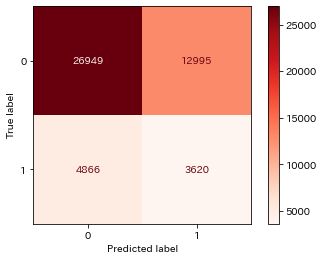

In [93]:
# 混同行列を表示
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

#F1スコアの計算
f1 = f1_score(y_test, y_pred)
print(f1)

#### ランダムフォレスト

In [94]:
#前処理
df = pd.read_csv('train.csv')
df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})

test = pd.read_csv('test.csv')
test.loan_status = 2

df = pd.concat([df, test], axis=0)

employment_list = {'0 years':0, '10 years':10, '1 year':1, '2 years':2, '3 years':3, '6 years':6,
                   '9 years':9, '7 years':7, '4 years':4, '5 years':5, '8 years':8}

df.term = df.term.replace({"3 years":3, "5 years":5})
df.employment_length = df.employment_length.replace(employment_list)
df.application_type = df.application_type.replace({"Individual":1, "Joint App":0}).astype(int)
df = pd.get_dummies(df, columns=["grade", "purpose"])

In [95]:
#追加した特徴量
m_grade = df.grade_B1 + df.grade_B2 + df.grade_B3 + df.grade_B4 + df.grade_B5 + df.grade_C1 + df.grade_C2

df['Availability'] = df.loan_amnt * df.term * df.interest_rate / df.employment_length * m_grade
df['Availability'] = df['Availability'].fillna(0)
df['Availability'] = df['Availability'].replace(np.inf, 500000)

df['Assesment'] = df.interest_rate / df.credit_score * m_grade

In [96]:
# 目的変数と説明変数の生成
train = df[:242150]
test = df[242150:]

x = train.drop('loan_status', axis=1)
y = train['loan_status']

x.shape, y.shape

((242150, 46), (242150,))

In [97]:
#学習・テストデータへの分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle = True)

In [98]:
#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier

# ランダムフォレスト
rfc = RandomForestClassifier(n_estimators=20, class_weight='balanced', random_state=42)
rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)

0.5400427998443638


In [99]:
y_pred = np.where(y_pred < 0.5, 0, 1)

0.16840243662802123


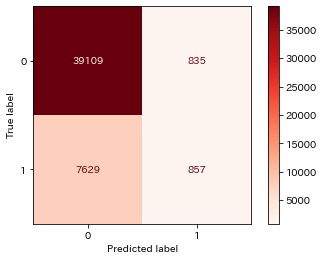

In [100]:
# 混同行列を表示
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

#F1スコアの計算
f1 = f1_score(y_test, y_pred)
print(f1)

####　ニューラルネットワーク

In [2]:
#前処理
df = pd.read_csv('train.csv')
df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})

test = pd.read_csv('test.csv')
test.loan_status = 2

df = pd.concat([df, test], axis=0)

employment_list = {'0 years':0, '10 years':10, '1 year':1, '2 years':2, '3 years':3, '6 years':6,
                   '9 years':9, '7 years':7, '4 years':4, '5 years':5, '8 years':8}

df.term = df.term.replace({"3 years":3, "5 years":5})
df.employment_length = df.employment_length.replace(employment_list)
df.application_type = df.application_type.replace({"Individual":1, "Joint App":0}).astype(int)
df = pd.get_dummies(df, columns=["grade", "purpose"])

In [3]:
#追加した特徴量
m_grade = df.grade_B1 + df.grade_B2 + df.grade_B3 + df.grade_B4 + df.grade_B5 + df.grade_C1 + df.grade_C2

df['Availability'] = df.loan_amnt * df.term * df.interest_rate / df.employment_length * m_grade
df['Availability'] = df['Availability'].fillna(0)
df['Availability'] = df['Availability'].replace(np.inf, 500000)

df['Assesment'] = df.interest_rate / df.credit_score * m_grade

In [4]:
# 目的変数と説明変数の生成
x = df.drop('loan_status', axis=1)
y = df['loan_status']

x.shape, y.shape

((269050, 46), (269050,))

In [5]:
from keras.models import Sequential
from sklearn.neural_network import MLPClassifier
from keras.layers import Dense, Activation, Dropout

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(x)
x = scaler.transform(x)

In [7]:
x_train = x[:242150]
y_train = y[:242150]

x_train2, x_valid, y_train2, y_valid = train_test_split(x_train, y_train, test_size=0.2, shuffle = True)

In [8]:
#ニューラルネットワーク
model = Sequential()
model.add(Dense(30, input_dim=46))    # 入力層46ノード, 全結合
model.add(Activation("relu"))
model.add(Dropout(rate=0.4))

model.add(Dense(30))    # 全結合
model.add(Activation("relu"))
model.add(Dropout(rate=0.4))

model.add(Dense(1)) # 出力層1ノード,全結合
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy",   # 誤差関数
              optimizer="adam", # 最適化手法
              metrics=['accuracy'])

In [9]:
from imblearn.under_sampling import RandomUnderSampler

def bagging(seed):
    sampler = RandomUnderSampler(random_state = seed)
    x_resampled, y_resampled = sampler.fit_resample(x_train2, y_train2)
    x_train3, x_valid2, y_train3, y_valid2 = train_test_split(x_resampled, y_resampled, test_size=0.2, shuffle = True)
    model.fit(x_train3, y_train3, epochs=1, batch_size=32, validation_data=(x_valid2, y_valid2))

In [22]:
preds = []

for i in range(5):
    bagging(i)

    y_pred = model.predict(x_valid)
    preds.append(y_pred)

    print(i, y_pred)

y_preds_bagging = sum(preds)/len(preds)

1514/1514 [==============================] - 3s 2ms/step
0 [[0.4365879 ]
 [0.6394911 ]
 [0.57533014]
 ...
 [0.58542454]
 [0.39722678]
 [0.58653903]]
1514/1514 [==============================] - 3s 2ms/step
1 [[0.42450017]
 [0.639178  ]
 [0.5881969 ]
 ...
 [0.5702241 ]
 [0.40206403]
 [0.57623446]]
1514/1514 [==============================] - 3s 2ms/step
2 [[0.43501642]
 [0.6405102 ]
 [0.5703013 ]
 ...
 [0.5826444 ]
 [0.37176654]
 [0.5835297 ]]
1514/1514 [==============================] - 3s 2ms/step
3 [[0.43971577]
 [0.62591803]
 [0.5913023 ]
 ...
 [0.5648443 ]
 [0.39345384]
 [0.5695064 ]]
1514/1514 [==============================] - 4s 3ms/step
4 [[0.4451682 ]
 [0.6070562 ]
 [0.58600384]
 ...
 [0.5695887 ]
 [0.3977636 ]
 [0.575564  ]]


In [23]:
# auc を計算する
fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_preds_bagging)
auc = metrics.auc(fpr, tpr)
print(auc)

0.7060313564256264


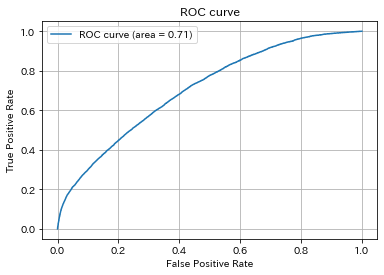

In [24]:
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

0.3821525667679514


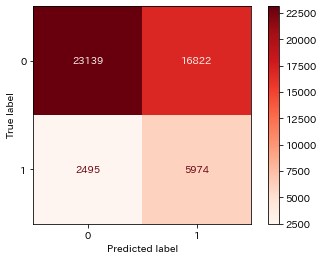

In [25]:
y_preds_bagging = np.where(y_preds_bagging < 0.5, 0, 1)

cm = confusion_matrix(y_valid, y_preds_bagging)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

#F1スコアの計算
f1 = f1_score(y_valid, y_preds_bagging)
print(f1)

#モデルのランダム性（サンプルや重み更新等）によって、安定しにくい様子

## 特徴量エンジニアリング
・信用スコアが中間クラスの場合、分類が難しい  
→このデータでは得られていない、その人の特性や状況が影響をしていそう

#### 間違えた予測の確認（1→0）

In [66]:
# # カレントディレクトリへモデルを保存
# file = 'trained_model.pkl'
# pickle.dump(model, open(file, 'wb'))

In [67]:
model = pickle.load(open('trained_model.pkl', 'rb'))

df = pd.read_csv('train.csv')
df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})

test = pd.read_csv('test.csv')
test.loan_status = 2

df = pd.concat([df, test], axis=0)

employment_list = {'0 years':0, '10 years':10, '1 year':1, '2 years':2, '3 years':3, '6 years':6,
                   '9 years':9, '7 years':7, '4 years':4, '5 years':5, '8 years':8}

df.term = df.term.replace({"3 years":3, "5 years":5})
df.employment_length = df.employment_length.replace(employment_list)
df.application_type = df.application_type.replace({"Individual":1, "Joint App":0}).astype(int)
df = pd.get_dummies(df, columns=["grade", "purpose"])

df = df[:242150]

In [68]:
# 予測
x = df.drop('loan_status', axis=1)
y_pred = model.predict(x)
y_pred = np.where(y_pred < 0.5, 0, 1)

In [69]:
df["pred_loan_status"] = y_pred
df

,id,loan_amnt,term,interest_rate,employment_length,credit_score,application_type,loan_status,grade_A1,grade_A2,grade_A3,grade_A4,grade_A5,grade_B1,grade_B2,grade_B3,grade_B4,grade_B5,grade_C1,grade_C2,grade_C3,grade_C4,grade_C5,grade_D1,grade_D2,grade_D3,grade_D4,grade_D5,grade_E1,grade_E2,grade_E3,grade_E4,grade_E5,grade_F3,grade_F5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,pred_loan_status
0,0,609.296068,3,8.421982,0,714.061803,1,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,1183.266999,5,10.286776,10,697.706701,1,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2,695.783256,3,14.723425,1,656.419357,1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,3,738.392546,3,14.260708,0,657.906852,1,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,4,1642.400654,5,25.217452,10,662.972297,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242145,242145,2427.939262,3,13.673803,8,657.206417,1,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
242146,242146,1224.346665,3,11.793595,10,699.763028,1,1.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
242147,242147,2089.513458,3,8.218123,1,724.556339,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
242148,242148,3459.367114,3,14.875958,9,688.249378,1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [70]:
df[((df['loan_status'] == 1) & (df['pred_loan_status'] == 1))].describe()

,id,loan_amnt,term,interest_rate,employment_length,credit_score,application_type,loan_status,grade_A1,grade_A2,grade_A3,grade_A4,grade_A5,grade_B1,grade_B2,grade_B3,grade_B4,grade_B5,grade_C1,grade_C2,grade_C3,grade_C4,grade_C5,grade_D1,grade_D2,grade_D3,grade_D4,grade_D5,grade_E1,grade_E2,grade_E3,grade_E4,grade_E5,grade_F3,grade_F5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,pred_loan_status
count,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.0,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.000000,29850.0,29850.000000,29850.000000,29850.0,29850.000000,29850.000000,29850.0
mean,119434.232529,1811.960779,3.964355,18.300713,6.808610,672.660286,0.994941,1.0,0.000201,0.007638,0.054204,0.007236,0.000134,0.020034,0.037387,0.004355,0.007203,0.075075,0.031960,0.034137,0.054204,0.141206,0.102814,0.056516,0.069514,0.067102,0.083618,0.075377,0.004657,0.031591,0.001340,0.022647,0.009648,0.000067,0.000134,0.006734,0.129112,0.744657,0.017387,0.0,0.004255,0.024958,0.0,0.070620,0.002278,1.0
std,69609.278326,862.046174,0.999381,4.359918,3.828878,18.620670,0.070945,0.0,0.014176,0.087064,0.226424,0.084759,0.011575,0.140117,0.189711,0.065850,0.084564,0.263517,0.175896,0.181585,0.226424,0.348240,0.303721,0.230919,0.254331,0.250203,0.276819,0.264003,0.068081,0.174912,0.036583,0.148776,0.097752,0.008185,0.011575,0.081784,0.335330,0.436061,0.130710,0.0,0.065090,0.156000,0.0,0.256193,0.047675,0.0
min,7.000000,379.329034,3.000000,6.476472,0.000000,655.571084,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0
25%,58826.250000,1144.858694,3.000000,14.572740,3.000000,658.878435,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0
50%,118908.000000,1604.097554,3.000000,17.972051,9.000000,662.902642,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0
75%,178955.250000,2300.988440,5.000000,22.700133,10.000000,680.980117,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0
max,242138.000000,3851.867974,5.000000,27.846030,10.000000,803.019415,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.0


In [71]:
df[((df['loan_status'] == 1) & (df['pred_loan_status'] == 0))].describe()

,id,loan_amnt,term,interest_rate,employment_length,credit_score,application_type,loan_status,grade_A1,grade_A2,grade_A3,grade_A4,grade_A5,grade_B1,grade_B2,grade_B3,grade_B4,grade_B5,grade_C1,grade_C2,grade_C3,grade_C4,grade_C5,grade_D1,grade_D2,grade_D3,grade_D4,grade_D5,grade_E1,grade_E2,grade_E3,grade_E4,grade_E5,grade_F3,grade_F5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,pred_loan_status
count,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.0,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.0,12506.0,12506.0,12506.000000,12506.000000,12506.000000,12506.000000,12506.0,12506.0,12506.000000,12506.0,12506.000000,12506.000000,12506.0
mean,122903.181673,1343.757310,3.170958,12.183561,6.563250,682.067314,0.990325,1.0,0.010715,0.007277,0.007436,0.024308,0.031505,0.091076,0.125700,0.116664,0.163122,0.056693,0.131057,0.100352,0.035663,0.021830,0.004398,0.035823,0.005917,0.015832,0.008876,0.003438,0.000480,0.000160,0.001439,0.000240,0.0,0.0,0.0,0.022789,0.243963,0.615305,0.036223,0.0,0.0,0.008956,0.0,0.071326,0.001439,0.0
std,69901.504833,751.385700,0.559209,2.611264,3.554617,26.748537,0.097890,0.0,0.102961,0.084995,0.085917,0.154011,0.174685,0.287729,0.331524,0.321032,0.369491,0.231264,0.337476,0.300481,0.185456,0.146132,0.066173,0.185856,0.076698,0.124832,0.093796,0.058539,0.021899,0.012646,0.037912,0.015487,0.0,0.0,0.0,0.149236,0.429488,0.486543,0.186851,0.0,0.0,0.094214,0.0,0.257379,0.037912,0.0
min,1.000000,377.291080,3.000000,5.878531,0.000000,655.674047,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
25%,62728.500000,700.595194,3.000000,10.831060,4.000000,659.404589,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
50%,123782.000000,1154.242379,3.000000,11.899013,7.000000,678.822528,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
75%,183684.250000,1630.201951,3.000000,13.709310,10.000000,698.067687,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
max,242146.000000,3738.232678,5.000000,23.644986,10.000000,803.365235,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,0.0,1.000000,1.000000,0.0


In [72]:
df[df['loan_status'] == 0].describe()

,id,loan_amnt,term,interest_rate,employment_length,credit_score,application_type,loan_status,grade_A1,grade_A2,grade_A3,grade_A4,grade_A5,grade_B1,grade_B2,grade_B3,grade_B4,grade_B5,grade_C1,grade_C2,grade_C3,grade_C4,grade_C5,grade_D1,grade_D2,grade_D3,grade_D4,grade_D5,grade_E1,grade_E2,grade_E3,grade_E4,grade_E5,grade_F3,grade_F5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,pred_loan_status
count,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.0,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.00000,199794.000000,199794.000000,199794.000000,199794.000000,199794.0,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.000000,199794.0,199794.000000,199794.000000,199794.000000
mean,121205.096970,1487.883222,3.368389,13.230569,6.658759,685.300103,0.992442,0.0,0.028149,0.027178,0.024130,0.044651,0.051989,0.068806,0.068415,0.072420,0.080853,0.061128,0.070943,0.058275,0.041052,0.072314,0.041523,0.041688,0.033404,0.030962,0.036142,0.022889,0.002478,0.00946,0.001792,0.008118,0.001236,0.000005,0.0,0.016862,0.210191,0.652092,0.033605,0.000020,0.000676,0.011497,0.0,0.073240,0.001817,0.370572
std,69942.519336,820.597028,0.775288,4.329162,3.636991,30.678399,0.086607,0.0,0.165399,0.162602,0.153453,0.206537,0.222004,0.253124,0.252458,0.259182,0.272610,0.239565,0.256730,0.234263,0.198412,0.259009,0.199496,0.199876,0.179691,0.173215,0.186644,0.149549,0.049713,0.09680,0.042292,0.089736,0.035139,0.002237,0.0,0.128756,0.407446,0.476308,0.180210,0.004474,0.025985,0.106605,0.0,0.260531,0.042586,0.482959
min,0.000000,323.797279,3.000000,5.704849,0.000000,655.424269,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,60633.250000,737.231143,3.000000,10.531426,3.000000,659.689445,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,121259.500000,1197.716418,3.000000,13.304132,8.000000,679.140967,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,181926.500000,2110.799423,3.000000,15.049202,10.000000,699.119452,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
max,242149.000000,3847.360998,5.000000,27.980604,10.000000,808.551641,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1

総額、期間、利子が低い人でも、グレードB1~C2までで、目的がカードや借金の人においては、稀に貸し倒れることがある  
→ちょっと上目のグレードで、カードや借金目的の人は調子に乗っている人であることが多く、数字上の信用があっても一定の確率で貸し倒れている？

In [73]:
#予測できていない人達を予測させるモデルを作って、特徴量重要度を確認してみる
df['object'] = df['loan_status'] - df['pred_loan_status']
df['object'] = df['object'].replace(-1,0)
df

,id,loan_amnt,term,interest_rate,employment_length,credit_score,application_type,loan_status,grade_A1,grade_A2,grade_A3,grade_A4,grade_A5,grade_B1,grade_B2,grade_B3,grade_B4,grade_B5,grade_C1,grade_C2,grade_C3,grade_C4,grade_C5,grade_D1,grade_D2,grade_D3,grade_D4,grade_D5,grade_E1,grade_E2,grade_E3,grade_E4,grade_E5,grade_F3,grade_F5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,pred_loan_status,object
0,0,609.296068,3,8.421982,0,714.061803,1,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0
1,1,1183.266999,5,10.286776,10,697.706701,1,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.0
2,2,695.783256,3,14.723425,1,656.419357,1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.0
3,3,738.392546,3,14.260708,0,657.906852,1,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0.0
4,4,1642.400654,5,25.217452,10,662.972297,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242145,242145,2427.939262,3,13.673803,8,657.206417,1,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0
242146,242146,1224.346665,3,11.793595,10,699.763028,1,1.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0
242147,242147,2089.513458,3,8.218123,1,724.556339,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0
242148,242148,3459.367114,3,14.875958,9,688.249378,1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.0


In [74]:
# 目的変数と説明変数の生成
x = df.drop(['object','loan_status',"pred_loan_status"], axis=1)
y = df['object']

x.shape, y.shape

((242150, 44), (242150,))

In [75]:
#学習・テストデータへの分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle = True)

In [76]:
#モデル構築
trains = lgb.Dataset(x_train, y_train)
valids = lgb.Dataset(x_test, y_test)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': -1,
    'subsample_freq': 1,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round":2000,
    "early_stopping_rounds": 100,
    'num_leaves': 30,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.9,
    'is_unbalance': True
}

model = lgb.train(params, trains, valid_sets = [trains, valids], keep_training_booster = True, verbose_eval =100)

C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.769187	valid_1's auc: 0.739091
[200]	training's auc: 0.77322	valid_1's auc: 0.740942
[300]	training's auc: 0.778381	valid_1's auc: 0.743593
[400]	training's auc: 0.782615	valid_1's auc: 0.744897
[500]	training's auc: 0.787068	valid_1's auc: 0.745704
[600]	training's auc: 0.791291	valid_1's auc: 0.746368
[700]	training's auc: 0.795114	valid_1's auc: 0.746689
[800]	training's auc: 0.798639	valid_1's auc: 0.7471
[900]	training's auc: 0.802307	valid_1's auc: 0.747338
[1000]	training's auc: 0.806225	valid_1's auc: 0.747586
[1100]	training's auc: 0.81002	valid_1's auc: 0.747911
[1200]	training's auc: 0.813552	valid_1's auc: 0.748081
[1300]	training's auc: 0.817261	valid_1's auc: 0.748352
[1400]	training's auc: 0.821226	valid_1's auc: 0.748631
[1500]	training's auc: 0.824686	valid_1's auc: 0.748766
[1600]	training's auc: 0.827844	valid_1's auc: 0.748834
[1700]	training's auc: 0.831052	valid_1's auc: 0.748934

In [77]:
#予測値の計算
y_pred = model.predict(x_test, num_iteration=model.best_iteration)
y_pred[:5]

array([0.00525238, 0.05367099, 0.03791904, 0.68669909, 0.42812211])

In [78]:
y_pred = np.where(y_pred < 0.5, 0, 1)

0.19148464844269197


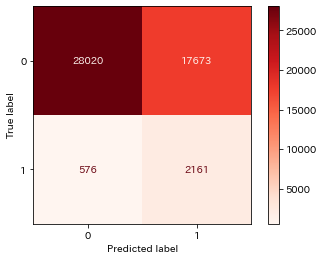

In [79]:
# 混同行列を表示
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

#F1スコアの計算
f1 = f1_score(y_test, y_pred)
print(f1)

In [80]:
#特徴量の寄与率
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=x_train.columns, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
display(importance[:50])

,importance
interest_rate,2.010233e+06
employment_length,8.955275e+05
credit_score,6.494573e+05
loan_amnt,5.088665e+05
id,3.280700e+05
term,3.033431e+05
grade_C5,2.093521e+05
grade_C4,2.074119e+05
purpose_debt_consolidation,1.643365e+05
grade_B3,1.415165e+05


In [301]:
# 特徴量の組み合わせの検証
# rare444のみが最もF1がよくなりそう

#総額、期間、利子が低い人、かつグレードが中間な人  
#df['rare4'] = df.loan_amnt * df.term * df.interest_rate *(df.grade_B1 + df.grade_B2 + df.grade_B3 + df.grade_B4 + df.grade_B5 + df.grade_C1 + df.grade_C2)

#総額、期間、利子が低い人、かつ勤務期間が短い人  
#df['rare10'] = df.loan_amnt * df.term * df.interest_rate * df.employment_length

#勤務期間が短い人、かつグレードが中間な人  
#df['rare44'] = df.employment_length *(df.grade_B1 + df.grade_B2 + df.grade_B3 + df.grade_B4 + df.grade_B5 + df.grade_C1 + df.grade_C2)

#総額、期間、利子が低い人、かつ勤務期間が短い人、かつグレードが中間な人  
df['rare444'] = df.loan_amnt *df.term * df.interest_rate * df.employment_length *(df.grade_B1 + df.grade_B2 + df.grade_B3 + df.grade_B4 + df.grade_B5 + df.grade_C1 + df.grade_C2)

#グレードが中間な人 、かつ目的が車かクレジットカードの人 
#df['rare5'] = (df.grade_B1 + df.grade_B2 + df.grade_B3 + df.grade_B4 + df.grade_B5 + df.grade_C1 + df.grade_C2) +(df.purpose_car + df.purpose_credit_card)
#df['rare5'] = df['rare5'].replace(1,0)

#総額、期間、利子が低い人、かつ目的が車かクレジットカードの人  
#df['rare1'] = df.loan_amnt * df.term * df.interest_rate * (df.purpose_car + df.purpose_credit_card)

#総額、期間、利子が低い人、かつ勤務期間が短い人、かつ目的が車かクレジットカードの人  
#df['rare111'] = df.loan_amnt * df.term * df.interest_rate * df.employment_length * (df.purpose_car + df.purpose_credit_card)

#勤務期間が短いが低い人、かつ目的が車かクレジットカードの人  
#df['rare11'] = df.employment_length * (df.purpose_car + df.purpose_credit_card)

#総額、期間、利子が低い人、かつ目的が家の補修か医療の人
#df['rare3'] = df.loan_amnt * df.term * df.interest_rate *(df.purpose_debt_consolidation + df.purpose_medical)

#グレードが中間な人 、かつ目的が家の補修か医療の人
#df['rare6'] = (df.grade_B1 + df.grade_B2 + df.grade_B3 + df.grade_B4 + df.grade_B5 + df.grade_C1 + df.grade_C2) +(df.purpose_debt_consolidation + df.purpose_medical)
#df['rare6'] = df['rare6'].replace(1,0)

#勤務期間が低い人、かつ目的が家の補修か医療の人
#df['rare33'] = df.employment_length *(df.purpose_debt_consolidation + df.purpose_medical)

#総額、期間、利子が低い人、かつ勤務期間が短い人、かつ目的が家の補修か医療の人
#df['rare333'] = df.loan_amnt * df.term * df.interest_rate * df.employment_length *(df.purpose_debt_consolidation + df.purpose_medical)

In [156]:
df[['rare10', 'rare4', 'rare44', 'rare5', 'rare1', 'rare6', 'rare3', 'loan_status']].corr()

,rare10,rare4,rare44,rare5,rare1,rare6,rare3,loan_status
rare10,1.000000,0.076596,-0.055847,-0.214339,0.193607,-0.228465,0.105670,0.171759
rare4,0.076596,1.000000,0.543804,0.517876,0.064197,0.619633,0.026285,0.008241
rare44,-0.055847,0.543804,1.000000,0.619050,-0.036351,0.728542,-0.024277,-0.061853
rare5,-0.214339,0.517876,0.619050,1.000000,0.394563,0.694418,-0.075734,-0.088284
rare1,0.193607,0.064197,-0.036351,0.394563,1.000000,-0.079273,-0.055101,0.019460
rare6,-0.228465,0.619633,0.728542,0.694418,-0.079273,1.000000,0.233753,-0.072532
rare3,0.105670,0.026285,-0.024277,-0.075734,-0.055101,0.233753,1.000000,0.025587
loan_status,0.171759,0.008241,-0.061853,-0.088284,0.019460,-0.072532,0.025587,1.000000


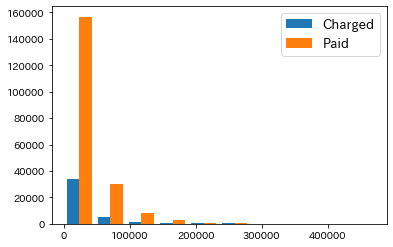

In [58]:
dataset1=df[df['loan_status']==1]['rare4']
dataset2=df[df['loan_status']==0]['rare4']

# グラフの描画
plt.hist([dataset1, dataset2], alpha=1, label=["Charged", "Paid"])
plt.legend(loc="best", fontsize=13) 

#### 間違えた予測の確認（0→1）

In [81]:
model = pickle.load(open('trained_model.pkl', 'rb'))

df = pd.read_csv('train.csv')
df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})

test = pd.read_csv('test.csv')
test.loan_status = 2

df = pd.concat([df, test], axis=0)

employment_list = {'0 years':0, '10 years':10, '1 year':1, '2 years':2, '3 years':3, '6 years':6,
                   '9 years':9, '7 years':7, '4 years':4, '5 years':5, '8 years':8}

df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})
df.term = df.term.replace({"3 years":3, "5 years":5})
df.employment_length = df.employment_length.replace(employment_list)
df.application_type = df.application_type.replace({"Individual":1, "Joint App":0}).astype(int)
df = pd.get_dummies(df, columns=["grade", "purpose"])

df = df[:242150]
x = df.drop('loan_status', axis=1)

In [82]:
# 予測
y_pred = model.predict(x)
y_pred = np.where(y_pred < 0.5, 0, 1)

In [83]:
df["pred_loan_status"] = y_pred
df

,id,loan_amnt,term,interest_rate,employment_length,credit_score,application_type,loan_status,grade_A1,grade_A2,grade_A3,grade_A4,grade_A5,grade_B1,grade_B2,grade_B3,grade_B4,grade_B5,grade_C1,grade_C2,grade_C3,grade_C4,grade_C5,grade_D1,grade_D2,grade_D3,grade_D4,grade_D5,grade_E1,grade_E2,grade_E3,grade_E4,grade_E5,grade_F3,grade_F5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,pred_loan_status
0,0,609.296068,3,8.421982,0,714.061803,1,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,1183.266999,5,10.286776,10,697.706701,1,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2,695.783256,3,14.723425,1,656.419357,1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,3,738.392546,3,14.260708,0,657.906852,1,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,4,1642.400654,5,25.217452,10,662.972297,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242145,242145,2427.939262,3,13.673803,8,657.206417,1,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
242146,242146,1224.346665,3,11.793595,10,699.763028,1,1.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
242147,242147,2089.513458,3,8.218123,1,724.556339,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
242148,242148,3459.367114,3,14.875958,9,688.249378,1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [84]:
df[((df['loan_status'] == 0) & (df['pred_loan_status'] == 0))].describe()

,id,loan_amnt,term,interest_rate,employment_length,credit_score,application_type,loan_status,grade_A1,grade_A2,grade_A3,grade_A4,grade_A5,grade_B1,grade_B2,grade_B3,grade_B4,grade_B5,grade_C1,grade_C2,grade_C3,grade_C4,grade_C5,grade_D1,grade_D2,grade_D3,grade_D4,grade_D5,grade_E1,grade_E2,grade_E3,grade_E4,grade_E5,grade_F3,grade_F5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,pred_loan_status
count,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.0,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.00000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.0,125756.0,125756.0,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.000000,125756.0,125756.000000,125756.000000,125756.0
mean,122408.299604,1361.264622,3.141767,11.075872,6.604432,692.158424,0.990195,0.0,0.044578,0.041103,0.030432,0.068895,0.082366,0.102914,0.094771,0.112384,0.123557,0.040674,0.088473,0.067210,0.022146,0.015840,0.004541,0.028341,0.005837,0.01091,0.007117,0.003411,0.000970,0.000334,0.002083,0.001113,0.0,0.0,0.0,0.021764,0.250135,0.601061,0.042328,0.000008,0.000087,0.007149,0.0,0.075790,0.001678,0.0
std,70359.825753,772.238092,0.513262,3.073365,3.524532,34.010989,0.098532,0.0,0.206377,0.198530,0.171773,0.253277,0.274922,0.303847,0.292899,0.315840,0.329076,0.197535,0.283983,0.250385,0.147159,0.124858,0.067231,0.165945,0.076175,0.10388,0.084062,0.058307,0.031132,0.018272,0.045597,0.033347,0.0,0.0,0.0,0.145914,0.433092,0.489682,0.201337,0.002820,0.009352,0.084248,0.0,0.264662,0.040927,0.0
min,0.000000,323.797279,3.000000,5.704849,0.000000,655.424269,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
25%,61218.750000,694.534839,3.000000,8.279300,4.000000,660.837478,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
50%,123030.500000,1150.421501,3.000000,11.083889,7.000000,683.673397,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
75%,184391.000000,1642.683856,3.000000,13.405846,10.000000,710.879937,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
max,242149.000000,3847.360998,5.000000,26.116983,10.000000,808.551641,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0


In [85]:
df[((df['loan_status'] == 0) & (df['pred_loan_status'] == 1))].describe()

,id,loan_amnt,term,interest_rate,employment_length,credit_score,application_type,loan_status,grade_A1,grade_A2,grade_A3,grade_A4,grade_A5,grade_B1,grade_B2,grade_B3,grade_B4,grade_B5,grade_C1,grade_C2,grade_C3,grade_C4,grade_C5,grade_D1,grade_D2,grade_D3,grade_D4,grade_D5,grade_E1,grade_E2,grade_E3,grade_E4,grade_E5,grade_F3,grade_F5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,pred_loan_status
count,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.0,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.0,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.000000,74038.0,74038.000000,74038.000000,74038.0
mean,119161.417367,1702.949116,3.753316,16.890394,6.751033,673.651016,0.996259,0.0,0.000243,0.003525,0.013426,0.003471,0.000392,0.010873,0.023650,0.004538,0.008320,0.095870,0.041168,0.043099,0.073165,0.168238,0.104338,0.064359,0.080229,0.065021,0.085443,0.055971,0.005038,0.024960,0.001297,0.020017,0.003336,0.000014,0.0,0.008536,0.142346,0.738769,0.018788,0.000041,0.001675,0.018882,0.0,0.068911,0.002053,1.0
std,69180.476435,854.832103,0.969102,3.640226,3.818681,18.957910,0.061052,0.0,0.015590,0.059269,0.115089,0.058815,0.019787,0.103705,0.151957,0.067214,0.090835,0.294414,0.198680,0.203082,0.260409,0.374080,0.305701,0.245393,0.271649,0.246564,0.279541,0.229868,0.070800,0.156005,0.035986,0.140058,0.057663,0.003675,0.0,0.091997,0.349407,0.439308,0.135775,0.006365,0.040891,0.136110,0.0,0.253304,0.045264,0.0
min,2.000000,352.000621,3.000000,6.619401,0.000000,655.493516,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
25%,59588.500000,1108.089481,3.000000,14.283567,3.000000,658.686851,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
50%,118528.500000,1551.372638,3.000000,16.996677,9.000000,663.589073,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
75%,177838.750000,2257.805330,5.000000,18.624848,10.000000,681.623178,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
max,242148.000000,3834.047751,5.000000,27.980604,10.000000,803.751362,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.0


In [86]:
df[df['loan_status'] == 1].describe()

,id,loan_amnt,term,interest_rate,employment_length,credit_score,application_type,loan_status,grade_A1,grade_A2,grade_A3,grade_A4,grade_A5,grade_B1,grade_B2,grade_B3,grade_B4,grade_B5,grade_C1,grade_C2,grade_C3,grade_C4,grade_C5,grade_D1,grade_D2,grade_D3,grade_D4,grade_D5,grade_E1,grade_E2,grade_E3,grade_E4,grade_E5,grade_F3,grade_F5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,pred_loan_status
count,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.0,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.000000,42356.0,42356.000000,42356.000000,42356.0,42356.000000,42356.000000,42356.000000
mean,120458.471787,1673.719383,3.730097,16.494567,6.736165,675.437798,0.993578,1.0,0.003305,0.007531,0.040396,0.012277,0.009397,0.041010,0.063462,0.037515,0.053239,0.069648,0.061219,0.053688,0.048730,0.105959,0.073756,0.050406,0.050737,0.051964,0.061550,0.054136,0.003423,0.022311,0.001369,0.016031,0.006800,0.000047,0.000094,0.011474,0.163023,0.706464,0.022948,0.0,0.002998,0.020233,0.0,0.070828,0.002030,0.704741
std,69712.824689,857.909096,0.962899,4.816208,3.751616,21.771709,0.079879,0.0,0.057397,0.086457,0.196888,0.110120,0.096480,0.198315,0.243795,0.190023,0.224513,0.254555,0.239735,0.225403,0.215305,0.307789,0.261376,0.218784,0.219462,0.221958,0.240339,0.226289,0.058410,0.147694,0.036980,0.125595,0.082179,0.006872,0.009718,0.106502,0.369391,0.455387,0.149741,0.0,0.054676,0.140799,0.0,0.256541,0.045015,0.456165
min,1.000000,377.291080,3.000000,5.878531,0.000000,655.571084,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,60054.250000,1090.632363,3.000000,13.319899,3.000000,659.000441,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,120160.500000,1536.721446,3.000000,14.931283,9.000000,664.190552,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
75%,180196.250000,2248.048420,5.000000,19.122801,10.000000,684.071151,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
max,242146.000000,3851.867974,5.000000,27.846030,10.000000,803.365235,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.00000

総額、期間、利子が低い人かつ？グレードB1~C2までの人でも、貸し倒れることがある（※目的がカードか借金であることが多い）  
→グレードが高めでも、貸し倒れる人はいる

総額、期間、利子が高い人かつ？グレードC3以下の人でも、貸し倒れないことも多い（※目的がカードか借金であることが多い）  
→グレードが低くても、真面目な人は一定数いる  

※目的にカードと借金の占める割合がそもそも高いため、重要な尺度として表れていそう

In [87]:
#予測できていない人達を予測させるモデルを作って、特徴量重要度を確認してみる
df['object'] = df['pred_loan_status'] - df['loan_status']
df['object'] = df['object'].replace(-1,0)
df

,id,loan_amnt,term,interest_rate,employment_length,credit_score,application_type,loan_status,grade_A1,grade_A2,grade_A3,grade_A4,grade_A5,grade_B1,grade_B2,grade_B3,grade_B4,grade_B5,grade_C1,grade_C2,grade_C3,grade_C4,grade_C5,grade_D1,grade_D2,grade_D3,grade_D4,grade_D5,grade_E1,grade_E2,grade_E3,grade_E4,grade_E5,grade_F3,grade_F5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,pred_loan_status,object
0,0,609.296068,3,8.421982,0,714.061803,1,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0
1,1,1183.266999,5,10.286776,10,697.706701,1,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0
2,2,695.783256,3,14.723425,1,656.419357,1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1.0
3,3,738.392546,3,14.260708,0,657.906852,1,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1.0
4,4,1642.400654,5,25.217452,10,662.972297,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242145,242145,2427.939262,3,13.673803,8,657.206417,1,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0
242146,242146,1224.346665,3,11.793595,10,699.763028,1,1.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0
242147,242147,2089.513458,3,8.218123,1,724.556339,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0
242148,242148,3459.367114,3,14.875958,9,688.249378,1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1.0


In [88]:
# 目的変数と説明変数の生成
x = df.drop(['object','loan_status',"pred_loan_status"], axis=1)
y = df['object']

x.shape, y.shape

((242150, 44), (242150,))

In [89]:
#学習・テストデータへの分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle = True)

In [90]:
#モデル構築
trains = lgb.Dataset(x_train, y_train)
valids = lgb.Dataset(x_test, y_test)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': -1,
    'subsample_freq': 1,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round":2000,
    "early_stopping_rounds": 100,
    'num_leaves': 30,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.9,
    'is_unbalance': True
}

model = lgb.train(params, trains, valid_sets = [trains, valids], keep_training_booster = True, verbose_eval =100)

C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.894703	valid_1's auc: 0.89427
[200]	training's auc: 0.899368	valid_1's auc: 0.898812
[300]	training's auc: 0.902749	valid_1's auc: 0.90202
[400]	training's auc: 0.905148	valid_1's auc: 0.904287
[500]	training's auc: 0.907241	valid_1's auc: 0.906272
[600]	training's auc: 0.908921	valid_1's auc: 0.907826
[700]	training's auc: 0.910287	valid_1's auc: 0.909011
[800]	training's auc: 0.911302	valid_1's auc: 0.909855
[900]	training's auc: 0.912216	valid_1's auc: 0.910629
[1000]	training's auc: 0.913035	valid_1's auc: 0.91129
[1100]	training's auc: 0.913797	valid_1's auc: 0.911854
[1200]	training's auc: 0.914509	valid_1's auc: 0.912354
[1300]	training's auc: 0.915102	valid_1's auc: 0.912723
[1400]	training's auc: 0.915745	valid_1's auc: 0.913077
[1500]	training's auc: 0.916326	valid_1's auc: 0.913385
[1600]	training's auc: 0.916891	valid_1's auc: 0.913667
[1700]	training's auc: 0.917424	valid_1's auc: 0.91393

In [91]:
#予測値の計算
y_pred = model.predict(x_test, num_iteration=model.best_iteration)
y_pred[:5]

array([8.49323079e-01, 8.32792404e-01, 8.91282670e-01, 5.99715523e-02,
       1.71613544e-04])

In [92]:
y_pred = np.where(y_pred < 0.5, 0, 1)

0.7950415551486124


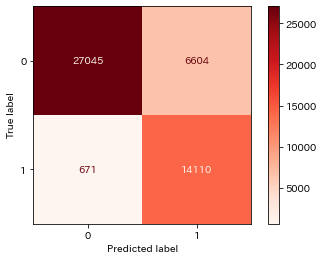

In [93]:
# 混同行列を表示
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

#F1スコアの計算
f1 = f1_score(y_test, y_pred)
print(f1)

In [94]:
#特徴量の寄与率
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=x_train.columns, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
display(importance[:30])

,importance
interest_rate,3.784697e+06
employment_length,6.796779e+05
credit_score,6.663742e+05
term,6.267612e+05
grade_B5,4.155538e+05
grade_B3,3.844906e+05
grade_B4,3.626699e+05
loan_amnt,3.399607e+05
grade_C4,2.948024e+05
grade_C5,1.868797e+05


In [ ]:
#検討する特徴量の追加
m_grade = df.grade_B1 + df.grade_B2 + df.grade_B3 + df.grade_B4 + df.grade_B5 + df.grade_C1 + df.grade_C2

df['Availability'] = df.loan_amnt * df.term * df.interest_rate / df.employment_length * m_grade
df['Assesment'] = df.interest_rate / df.credit_score * m_grade

#### ノイズの判定

In [365]:
#前処理
df = pd.read_csv('train.csv')
df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})

test = pd.read_csv('test.csv')
test.loan_status = 2

df = pd.concat([df, test], axis=0)

employment_list = {'0 years':0, '10 years':10, '1 year':1, '2 years':2, '3 years':3, '6 years':6,
                   '9 years':9, '7 years':7, '4 years':4, '5 years':5, '8 years':8}

df.term = df.term.replace({"3 years":3, "5 years":5})
df.employment_length = df.employment_length.replace(employment_list)
df.application_type = df.application_type.replace({"Individual":1, "Joint App":0}).astype(int)
df = pd.get_dummies(df, columns=["grade", "purpose"])

In [366]:
#追加した特徴量
m_grade = df.grade_B1 + df.grade_B2 + df.grade_B3 + df.grade_B4 + df.grade_B5 + df.grade_C1 + df.grade_C2

df['Availability'] = df.loan_amnt * df.term * df.interest_rate / df.employment_length * m_grade
df['Assesment'] = df.interest_rate / df.credit_score * m_grade

In [367]:
# 目的変数と説明変数の生成
train = df[:242150]
test = df[242150:]

x = train.drop('loan_status', axis=1)
y = train['loan_status']

#学習・テストデータへの分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle = True)

In [ ]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': -1,
    'subsample_freq': 1,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round":20000,
    "early_stopping_rounds": 100,
    'num_leaves': 30,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.9,
    'is_unbalance': True,
}

def get_feature_importance(x_train, y_train):
    
    trains = lgb.Dataset(x_train, y_train)
    valids = lgb.Dataset(x_test, y_test)

    # モデルの学習
    model = lgb.train(params, trains, valid_sets = [trains, valids], keep_training_booster = True, verbose_eval =300)

    # 特徴量の重要度を含むデータフレームを作成
    imp_df = pd.DataFrame({'feature': x.columns,'importance':model.feature_importance(importance_type='gain')})
    return imp_df.sort_values('importance', ascending=False)

# 実際の目的変数でモデルを学習し、特徴量の重要度を含むデータフレームを作成
actual_imp_df = get_feature_importance(x_train, y_train)

# 目的変数をシャッフルした状態でモデルを学習し、特徴量の重要度を含むデータフレームを作成
null_imp_df = pd.DataFrame()

for i in range(10):
    y_train = np.random.permutation(y_train)
    imp_df = get_feature_importance(x_train, y_train)
    imp_df["run"] = i + 1
    null_imp_df = pd.concat([null_imp_df, imp_df])

In [370]:
actual_imp_df

,feature,importance
3,interest_rate,1.348363e+06
5,credit_score,2.688103e+05
44,Availability,1.868491e+05
2,term,1.537736e+05
45,Assesment,1.525391e+05
1,loan_amnt,1.406500e+05
4,employment_length,1.048272e+05
0,id,9.997807e+04
11,grade_A5,4.145524e+04
9,grade_A3,4.126282e+04


In [369]:
mean_imp_df = pd.DataFrame(null_imp_df.groupby("feature")["importance"].mean())
mean_imp_df = mean_imp_df.reset_index()
mean_imp_df = mean_imp_df.rename(columns={'importance': 'null_importance'})
mean_imp_df = mean_imp_df.sort_values('null_importance', ascending=False)
mean_imp_df

,feature,null_importance
32,id,709.078087
34,loan_amnt,690.627376
33,interest_rate,665.735624
1,Availability,505.687592
3,credit_score,501.574541
0,Assesment,235.450217
4,employment_length,211.598323
37,purpose_debt_consolidation,72.466372
38,purpose_home_improvement,71.447141
12,grade_B3,59.993563


In [ ]:
# https://qiita.com/trapi/items/1d6ede5d492d1a9dc3c9

## Optuna
・モデルのパラメータ  
・閾値

#### パラメータを最適化

In [ ]:
from optuna.integration import lightgbm as olgb

trains = olgb.Dataset(x_train, y_train)
valids = olgb.Dataset(x_test, y_test)

# 固定するパラメータ
params = {
    "boosting_type": "gbdt",
    'objective': 'binary',
    'metric': 'auc',
    "boosting": "gbdt",
    'learning_rate': 0.01,
    "verbosity": -1,
    "random_state": 26,
    'subsample_freq': 1,
    'is_unbalance': True
}

best_params, history = {}, []

# Optunaでパラメータ探索
model = olgb.train(params, trains, 
                  valid_sets=[trains, valids],
                  verbose_eval=300,
                  num_boost_round=2000,
                  early_stopping_rounds=100
                 )

# 最適なパラメータの表示
best_params = model.params
print("Best params:", best_params)

In [585]:
#モデル構築
trains = lgb.Dataset(x_train, y_train)
valids = lgb.Dataset(x_test, y_test)

params = {'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc', 
          'learning_rate': 0.01, 
          'verbosity': -1, 
          'random_state': 42, 
          'is_unbalance': True, 
          'feature_pre_filter': False, 
          'bagging_freq': 1, 
          'lambda_l1': 0, 
          'lambda_l2': 0, 
          'num_leaves': 32, 
          'feature_fraction': 0.5, 
          'bagging_fraction': 1, 
          'min_child_samples': 20, 
          'num_iterations': 3000, 
          'early_stopping_round': 100}

model = lgb.train(params, trains, valid_sets = [trains, valids], keep_training_booster = True, verbose_eval =100)

C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.715669	valid_1's auc: 0.714154
[200]	training's auc: 0.718504	valid_1's auc: 0.715982
[300]	training's auc: 0.721321	valid_1's auc: 0.717461
[400]	training's auc: 0.723894	valid_1's auc: 0.718709
[500]	training's auc: 0.726245	valid_1's auc: 0.719553
[600]	training's auc: 0.728238	valid_1's auc: 0.720019
[700]	training's auc: 0.730322	valid_1's auc: 0.720411
[800]	training's auc: 0.732168	valid_1's auc: 0.720594
[900]	training's auc: 0.734141	valid_1's auc: 0.720749
[1000]	training's auc: 0.736068	valid_1's auc: 0.720912
[1100]	training's auc: 0.737893	valid_1's auc: 0.721063
[1200]	training's auc: 0.739749	valid_1's auc: 0.721131
[1300]	training's auc: 0.741542	valid_1's auc: 0.721143
Early stopping, best iteration is:
[1268]	training's auc: 0.740991	valid_1's auc: 0.721172


In [591]:
#予測値の計算
y_pred = model.predict(x_test, num_iteration=model.best_iteration)
y_pred[:5]

array([0.56181965, 0.54772972, 0.64126962, 0.46085491, 0.15851932])

In [592]:
#AUCの計算
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)

0.7211724124120221


In [593]:
y_pred = np.where(y_pred < 0.5, 0, 1)

0.39863702072003854


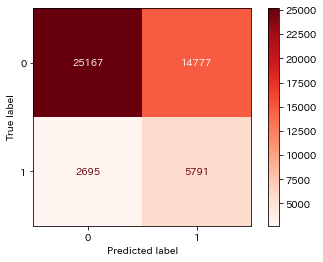

In [594]:
# 混同行列を表示
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

#F1スコアの計算
f1 = f1_score(y_test, y_pred)
print(f1)

#### 閾値を最適化

In [78]:
import optuna

def f1(y_test, y_pred, threshold):
    y_pred = [1 if prob >= threshold else 0 for prob in y_pred]
    score = f1_score(y_test, y_pred)
    return score

# 目的関数
def objective(trial): 
    threshold = trial.suggest_float('threshold', 0.0, 1.0) # 0~1.0で探索
    ret = f1(y_test, y_pred, threshold)
    return ret

# 最適化
# n_trialsが多ければ多いほど◎
study = optuna.create_study(direction="maximize") 
study.optimize(objective, n_trials=10)

print(study.best_value)
print(study.best_params)

[I 2022-11-04 14:08:40,305] A new study created in memory with name: no-name-f0608a74-cea2-411e-8ee0-4849129ccedb
[I 2022-11-04 14:08:40,429] Trial 0 finished with value: 0.3496777315823049 and parameters: {'threshold': 0.31189054568582397}. Best is trial 0 with value: 0.3496777315823049.
[I 2022-11-04 14:08:40,530] Trial 1 finished with value: 0.28372132111942183 and parameters: {'threshold': 0.7022187366867404}. Best is trial 0 with value: 0.3496777315823049.
[I 2022-11-04 14:08:40,630] Trial 2 finished with value: 0.34387125500922333 and parameters: {'threshold': 0.28314571130396715}. Best is trial 0 with value: 0.3496777315823049.
[I 2022-11-04 14:08:40,729] Trial 3 finished with value: 0.32756830868671044 and parameters: {'threshold': 0.16217155560897445}. Best is trial 0 with value: 0.3496777315823049.
[I 2022-11-04 14:08:40,826] Trial 4 finished with value: 0.3003881120740071 and parameters: {'threshold': 0.0492567255223515}. Best is trial 0 with value: 0.3496777315823049.
[I 20

0.39573451964279877
{'threshold': 0.4853176539674302}


In [79]:
optuna_y_pred = np.where(y_pred < 0.5362122618973053, 0, 1)

0.4012338260625726


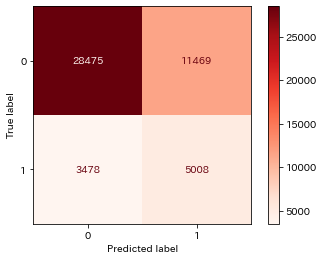

In [80]:
# 混同行列を表示
cm = confusion_matrix(y_test, optuna_y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

#F1スコアの計算
f1 = f1_score(y_test, optuna_y_pred)
print(f1)

0.3989392843613321


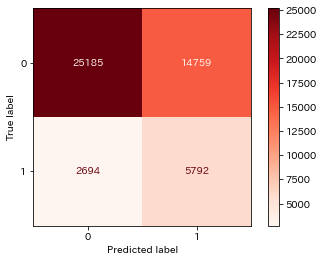

In [81]:
# 混同行列を表示
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

#F1スコアの計算
f1 = f1_score(y_test, y_pred)
print(f1)

## 層化k分割交差検証
過学習を防ぎ、汎化性能を高める

In [592]:
#前処理
df = pd.read_csv('train.csv')
df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})

test = pd.read_csv('test.csv')
test.loan_status = 10

df = pd.concat([df, test], axis=0)

employment_list = {'0 years':0, '10 years':10, '1 year':1, '2 years':2, '3 years':3, '6 years':6,
                   '9 years':9, '7 years':7, '4 years':4, '5 years':5, '8 years':8}

df.term = df.term.replace({"3 years":3, "5 years":5})
df.employment_length = df.employment_length.replace(employment_list)
df.application_type = df.application_type.replace({"Individual":1, "Joint App":0}).astype(int)
df = pd.get_dummies(df, columns=["grade", "purpose"])

In [593]:
#追加した特徴量
m_grade = df.grade_B1 + df.grade_B2 + df.grade_B3 + df.grade_B4 + df.grade_B5 + df.grade_C1 + df.grade_C2

df['Availability'] = df.loan_amnt * df.term * df.interest_rate / df.employment_length * m_grade
df['Assesment'] = df.interest_rate / df.credit_score * m_grade

In [594]:
# 目的変数と説明変数の生成
train = df[:242150]
test = df[242150:]

x = train.drop('loan_status', axis=1)
y = train['loan_status']

x.shape, y.shape

((242150, 46), (242150,))

In [595]:
#学習・テストデータへの分割
models = []
valid_scores = []

from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in kf.split(x, y):
            
    x_train = x.iloc[train_index]
    y_train = y.iloc[train_index]
    x_test = x.iloc[test_index]
    y_test = y.iloc[test_index]
    
    trains = lgb.Dataset(x_train, y_train)
    valids = lgb.Dataset(x_test, y_test)

    params = {
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': -1,
    'subsample_freq': 1,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round":20000,
    "early_stopping_rounds": 100,
    'num_leaves': 30,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.9,
    'is_unbalance': True,
    }

    model = lgb.train(params, trains, valid_sets = [trains, valids], keep_training_booster = True, verbose_eval =300)

    y_pred = model.predict(x_test, num_iteration=model.best_iteration)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)

    models.append(model)
    valid_scores.append(auc)

C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.72306	valid_1's auc: 0.714366
[600]	training's auc: 0.731131	valid_1's auc: 0.716679
[900]	training's auc: 0.738156	valid_1's auc: 0.717271
[1200]	training's auc: 0.744781	valid_1's auc: 0.717683
[1500]	training's auc: 0.750968	valid_1's auc: 0.717905
Early stopping, best iteration is:
[1509]	training's auc: 0.751137	valid_1's auc: 0.717916


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.721562	valid_1's auc: 0.717829
[600]	training's auc: 0.729759	valid_1's auc: 0.720233
[900]	training's auc: 0.736982	valid_1's auc: 0.720646
[1200]	training's auc: 0.743873	valid_1's auc: 0.720784
Early stopping, best iteration is:
[1168]	training's auc: 0.743167	valid_1's auc: 0.720804


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.723503	valid_1's auc: 0.713762
[600]	training's auc: 0.731457	valid_1's auc: 0.715859
[900]	training's auc: 0.738253	valid_1's auc: 0.716419
[1200]	training's auc: 0.744704	valid_1's auc: 0.716653
[1500]	training's auc: 0.750779	valid_1's auc: 0.716735
Early stopping, best iteration is:
[1555]	training's auc: 0.751838	valid_1's auc: 0.716773


In [596]:
valid_scores

[0.7179157677815048, 0.7208038489219646, 0.7167725707967945]

In [597]:
y_preds = []

for i in range(3):
    y_preds.append(models[i].predict(x_test, num_iteration=models[i].best_iteration))

y_preds_bagging = sum(y_preds)/len(y_preds)
y_preds_bagging = np.where(y_preds_bagging < 0.5, 0, 1)

0.407373915902832


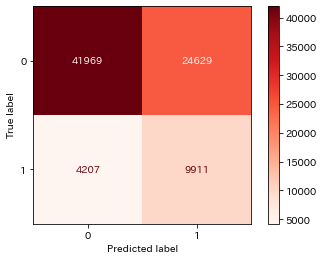

In [598]:
# 混同行列を表示
cm = confusion_matrix(y_test, y_preds_bagging)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

#F1スコアの計算
f1 = f1_score(y_test, y_preds_bagging)
print(f1)

## ランダムシードアベレージ
・サンプリングによるばらつきを軽減

In [102]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle = True)

def Search(random):
        
    params = {'objective': 'binary',
          'metric': 'auc',
          'max_depth': -1,
          'subsample_freq': 1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "random_state": random,
          "verbosity": -1,
          "num_boost_round":2000,
          "early_stopping_rounds": 100,
          'num_leaves': 30,
          'feature_fraction': 0.6,
          'bagging_fraction': 0.9,
          'is_unbalance': True}
    
    trains = lgb.Dataset(x_train, y_train)
    valids = lgb.Dataset(x_test, y_test)

    model_bagging = lgb.train(params, trains, valid_sets = [trains, valids], keep_training_booster = True, verbose_eval =300)
    return model_bagging

In [408]:
models = []
f1s = []

for i in range(10):
    models.append(Search(i))

    y_pred = models[i].predict(x_test, num_iteration=models[i].best_iteration)
    y_pred = np.where(y_pred < 0.5, 0, 1)
    f1s.append(f1_score(y_test, y_pred))

    print(i,f1s)

C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.721293	valid_1's auc: 0.717684
[600]	training's auc: 0.728754	valid_1's auc: 0.720129
[900]	training's auc: 0.734591	valid_1's auc: 0.720717
[1200]	training's auc: 0.740412	valid_1's auc: 0.721008
Early stopping, best iteration is:
[1229]	training's auc: 0.740876	valid_1's auc: 0.721051
0 [0.39701943547833257]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.721125	valid_1's auc: 0.717529
[600]	training's auc: 0.728387	valid_1's auc: 0.720105
[900]	training's auc: 0.734659	valid_1's auc: 0.720915
[1200]	training's auc: 0.74043	valid_1's auc: 0.721149
Early stopping, best iteration is:
[1298]	training's auc: 0.742256	valid_1's auc: 0.721188
1 [0.39701943547833257, 0.397126555303499]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.721091	valid_1's auc: 0.717612
[600]	training's auc: 0.728341	valid_1's auc: 0.720297
[900]	training's auc: 0.734568	valid_1's auc: 0.720864
[1200]	training's auc: 0.740318	valid_1's auc: 0.721199
[1500]	training's auc: 0.745647	valid_1's auc: 0.721382
[1800]	training's auc: 0.750851	valid_1's auc: 0.72139
Early stopping, best iteration is:
[1723]	training's auc: 0.749528	valid_1's auc: 0.721446
2 [0.39701943547833257, 0.397126555303499, 0.3981039374437755]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.721087	valid_1's auc: 0.717467
[600]	training's auc: 0.728147	valid_1's auc: 0.71995
[900]	training's auc: 0.734354	valid_1's auc: 0.720686
[1200]	training's auc: 0.74003	valid_1's auc: 0.721038
[1500]	training's auc: 0.745336	valid_1's auc: 0.72118
Early stopping, best iteration is:
[1480]	training's auc: 0.745008	valid_1's auc: 0.721196
3 [0.39701943547833257, 0.397126555303499, 0.3981039374437755, 0.3981385729058945]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.721182	valid_1's auc: 0.717468
[600]	training's auc: 0.728484	valid_1's auc: 0.720353
[900]	training's auc: 0.734496	valid_1's auc: 0.720991
[1200]	training's auc: 0.740191	valid_1's auc: 0.721238
Early stopping, best iteration is:
[1393]	training's auc: 0.74358	valid_1's auc: 0.721345
4 [0.39701943547833257, 0.397126555303499, 0.3981039374437755, 0.3981385729058945, 0.3973802137194071]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.721038	valid_1's auc: 0.717191
[600]	training's auc: 0.728355	valid_1's auc: 0.72
[900]	training's auc: 0.734485	valid_1's auc: 0.720774
[1200]	training's auc: 0.740207	valid_1's auc: 0.721107
Early stopping, best iteration is:
[1282]	training's auc: 0.741678	valid_1's auc: 0.721216
5 [0.39701943547833257, 0.397126555303499, 0.3981039374437755, 0.3981385729058945, 0.3973802137194071, 0.39735464315238356]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.721156	valid_1's auc: 0.717515
[600]	training's auc: 0.728451	valid_1's auc: 0.720085
[900]	training's auc: 0.734632	valid_1's auc: 0.720699
[1200]	training's auc: 0.740328	valid_1's auc: 0.721118
[1500]	training's auc: 0.745798	valid_1's auc: 0.721191
Early stopping, best iteration is:
[1620]	training's auc: 0.747832	valid_1's auc: 0.721236
6 [0.39701943547833257, 0.397126555303499, 0.3981039374437755, 0.3981385729058945, 0.3973802137194071, 0.39735464315238356, 0.39823588188677944]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.721253	valid_1's auc: 0.717723
[600]	training's auc: 0.728274	valid_1's auc: 0.72028
[900]	training's auc: 0.734732	valid_1's auc: 0.721093
[1200]	training's auc: 0.740489	valid_1's auc: 0.721316
[1500]	training's auc: 0.745924	valid_1's auc: 0.721476
Early stopping, best iteration is:
[1409]	training's auc: 0.744261	valid_1's auc: 0.721496
7 [0.39701943547833257, 0.397126555303499, 0.3981039374437755, 0.3981385729058945, 0.3973802137194071, 0.39735464315238356, 0.39823588188677944, 0.3983605428118757]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.721094	valid_1's auc: 0.717581
[600]	training's auc: 0.728346	valid_1's auc: 0.720379
[900]	training's auc: 0.734659	valid_1's auc: 0.720913
[1200]	training's auc: 0.740535	valid_1's auc: 0.721152
Early stopping, best iteration is:
[1250]	training's auc: 0.741543	valid_1's auc: 0.721212
8 [0.39701943547833257, 0.397126555303499, 0.3981039374437755, 0.3981385729058945, 0.3973802137194071, 0.39735464315238356, 0.39823588188677944, 0.3983605428118757, 0.3980198700539723]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.721199	valid_1's auc: 0.717569
[600]	training's auc: 0.728401	valid_1's auc: 0.720112
[900]	training's auc: 0.734589	valid_1's auc: 0.720796
[1200]	training's auc: 0.740337	valid_1's auc: 0.720977
[1500]	training's auc: 0.74561	valid_1's auc: 0.721072
Early stopping, best iteration is:
[1409]	training's auc: 0.744056	valid_1's auc: 0.721099
9 [0.39701943547833257, 0.397126555303499, 0.3981039374437755, 0.3981385729058945, 0.3973802137194071, 0.39735464315238356, 0.39823588188677944, 0.3983605428118757, 0.3980198700539723, 0.39746939898225836]


In [409]:
f1_list = pd.DataFrame(f1s)
f1_list[0].sort_values(ascending=False)[:50]

7    0.398361
6    0.398236
3    0.398139
2    0.398104
8    0.398020
9    0.397469
4    0.397380
5    0.397355
1    0.397127
0    0.397019
Name: 0, dtype: float64

In [600]:
list = [42,90,26]

In [410]:
y_preds = []

for i in range(10):
    y_preds.append(models[i].predict(x_test, num_iteration=models[i].best_iteration))

y_preds_bagging = sum(y_preds)/len(y_preds)

# auc を計算する
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds_bagging)
auc = metrics.auc(fpr, tpr)
print(auc)

0.7213758701257886


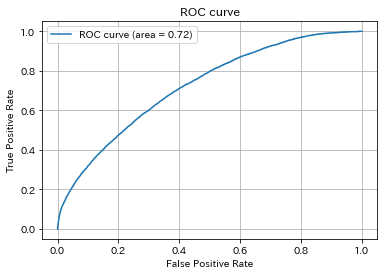

In [411]:
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

0.3981666551795438


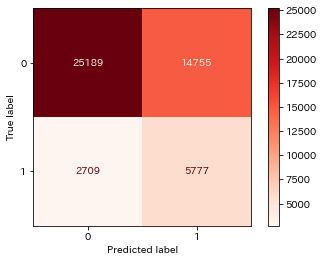

In [412]:
y_preds_bagging = np.where(y_preds_bagging < 0.5, 0, 1)

cm = confusion_matrix(y_test, y_preds_bagging)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

#F1スコアの計算
f1 = f1_score(y_test, y_preds_bagging)
print(f1)

## 不均衡データへの対処の検討
・ダウンサンプリング／オーバーサンプリング

#### ダウンサンプリング

In [64]:
#前処理
df = pd.read_csv('train.csv')
df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})

test = pd.read_csv('test.csv')
test.loan_status = 2

df = pd.concat([df, test], axis=0)

employment_list = {'0 years':0, '10 years':10, '1 year':1, '2 years':2, '3 years':3, '6 years':6,
                   '9 years':9, '7 years':7, '4 years':4, '5 years':5, '8 years':8}

df.term = df.term.replace({"3 years":3, "5 years":5})
df.employment_length = df.employment_length.replace(employment_list)
df.application_type = df.application_type.replace({"Individual":1, "Joint App":0}).astype(int)
df = pd.get_dummies(df, columns=["grade", "purpose"])

In [65]:
#追加した特徴量
m_grade = df.grade_B1 + df.grade_B2 + df.grade_B3 + df.grade_B4 + df.grade_B5 + df.grade_C1 + df.grade_C2

df['Availability'] = df.loan_amnt * df.term * df.interest_rate / df.employment_length * m_grade
df['Availability'] = df['Availability'].fillna(0)
df['Availability'] = df['Availability'].replace(np.inf, 500000)

df['Assesment'] = df.interest_rate / df.credit_score * m_grade

In [31]:
# 目的変数と説明変数の生成
train = df[:242150]
test = df[242150:]

x = train.drop('loan_status', axis=1)
y = train['loan_status']

x.shape, y.shape

((242150, 46), (242150,))

In [32]:
#ダウンサンプリング
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle = True)

In [141]:
# #毎回全探索させる
# from optuna.integration import lightgbm as olgb

# trains = olgb.Dataset(x_train, y_train)
# valids = olgb.Dataset(x_test, y_test)

# # 固定するパラメータ
# params = {
#     "boosting_type": "gbdt",
#     'objective': 'binary',
#     'metric': 'auc',
#     "boosting": "gbdt",
#     'learning_rate': 0.01,
#     "verbosity": -1,
#     "random_state": 42,
#     'subsample_freq': 1,
#     'is_unbalance': True
# }

# def bagging(seed):
#     sampler = RandomUnderSampler(random_state = seed)
#     X1_resampled, y_resampled = sampler.fit_resample(x, y)
#     X_train2, X_valid, y_train2, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, shuffle = True)
    
#     trains = olgb.Dataset(X_train2, y_train2)
#     valids = olgb.Dataset(X_valid, y_valid)
    
#     best_params = {}

#     omodel = olgb.train(params, trains, valid_sets = [trains, valids], keep_training_booster = True, verbose_eval =100, num_boost_round=1000, early_stopping_rounds=100)
#     best_params = model.params
#     model_bagging = lgb.train(best_params, trains, valid_sets = [trains, valids], keep_training_booster = True, verbose_eval =100, num_boost_round=1000, early_stopping_rounds=100)
#     return model_bagging


In [33]:
params = {'objective': 'binary',
          'metric': 'auc',
          'max_depth': -1,
          'subsample_freq': 1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "verbosity": -1,
          "random_state": 42,
          "num_boost_round":2000,
          "early_stopping_rounds": 100,
          'num_leaves': 30,
          'feature_fraction': 0.6,
          'bagging_fraction': 0.9,
          'is_unbalance': True}

from imblearn.under_sampling import RandomUnderSampler

def bagging(seed):
    sampler = RandomUnderSampler(random_state = seed)
    X_resampled, y_resampled = sampler.fit_resample(x_train, y_train)
    X_train2, X_valid, y_train2, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, shuffle = True)
    
    trains = lgb.Dataset(X_train2, y_train2)
    valids = lgb.Dataset(x_test, y_test)
    
    model_bagging = lgb.train(params, trains, valid_sets = [trains, valids], verbose_eval =300, keep_training_booster = True)
    return model_bagging

In [34]:
models = []
f1s = []

for i in range(10):
    models.append(bagging(i))

    y_pred = models[i].predict(x_test, num_iteration=models[i].best_iteration)
    y_pred = np.where(y_pred < 0.5, 0, 1)
    f1s.append(f1_score(y_test, y_pred))

    print(i,f1s)

C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.727224	valid_1's auc: 0.715892
[600]	training's auc: 0.739516	valid_1's auc: 0.71859
[900]	training's auc: 0.750215	valid_1's auc: 0.71926
[1200]	training's auc: 0.760546	valid_1's auc: 0.719551
Early stopping, best iteration is:
[1271]	training's auc: 0.762897	valid_1's auc: 0.719617
0 [0.39440835345736536]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.725149	valid_1's auc: 0.715986
[600]	training's auc: 0.737363	valid_1's auc: 0.718277
[900]	training's auc: 0.748426	valid_1's auc: 0.718721
[1200]	training's auc: 0.758431	valid_1's auc: 0.718869
Early stopping, best iteration is:
[1134]	training's auc: 0.756271	valid_1's auc: 0.718929
1 [0.39440835345736536, 0.3953969924301572]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.725676	valid_1's auc: 0.715288
[600]	training's auc: 0.737726	valid_1's auc: 0.717509
[900]	training's auc: 0.748333	valid_1's auc: 0.717861
Early stopping, best iteration is:
[850]	training's auc: 0.746369	valid_1's auc: 0.717896
2 [0.39440835345736536, 0.3953969924301572, 0.3940809437757851]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.726831	valid_1's auc: 0.716476
[600]	training's auc: 0.738979	valid_1's auc: 0.718646
[900]	training's auc: 0.749908	valid_1's auc: 0.718998
Early stopping, best iteration is:
[1004]	training's auc: 0.753527	valid_1's auc: 0.719128
3 [0.39440835345736536, 0.3953969924301572, 0.3940809437757851, 0.3951804011882113]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.724901	valid_1's auc: 0.716495
[600]	training's auc: 0.737125	valid_1's auc: 0.718815
[900]	training's auc: 0.748302	valid_1's auc: 0.719308
Early stopping, best iteration is:
[955]	training's auc: 0.750338	valid_1's auc: 0.719376
4 [0.39440835345736536, 0.3953969924301572, 0.3940809437757851, 0.3951804011882113, 0.39566395663956644]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.725638	valid_1's auc: 0.715778
[600]	training's auc: 0.737851	valid_1's auc: 0.717934
[900]	training's auc: 0.748443	valid_1's auc: 0.718453
Early stopping, best iteration is:
[903]	training's auc: 0.748554	valid_1's auc: 0.718483
5 [0.39440835345736536, 0.3953969924301572, 0.3940809437757851, 0.3951804011882113, 0.39566395663956644, 0.3945794329356899]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.726574	valid_1's auc: 0.716004
[600]	training's auc: 0.738419	valid_1's auc: 0.718293
[900]	training's auc: 0.749516	valid_1's auc: 0.718776
[1200]	training's auc: 0.759403	valid_1's auc: 0.718931
Early stopping, best iteration is:
[1141]	training's auc: 0.757476	valid_1's auc: 0.718959
6 [0.39440835345736536, 0.3953969924301572, 0.3940809437757851, 0.3951804011882113, 0.39566395663956644, 0.3945794329356899, 0.395141535111595]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.724413	valid_1's auc: 0.715837
[600]	training's auc: 0.736443	valid_1's auc: 0.718422
[900]	training's auc: 0.747269	valid_1's auc: 0.718875
Early stopping, best iteration is:
[818]	training's auc: 0.744361	valid_1's auc: 0.718911
7 [0.39440835345736536, 0.3953969924301572, 0.3940809437757851, 0.3951804011882113, 0.39566395663956644, 0.3945794329356899, 0.395141535111595, 0.3968405935854476]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.726079	valid_1's auc: 0.716892
[600]	training's auc: 0.737645	valid_1's auc: 0.719323
[900]	training's auc: 0.748302	valid_1's auc: 0.71985
Early stopping, best iteration is:
[1095]	training's auc: 0.75515	valid_1's auc: 0.720034
8 [0.39440835345736536, 0.3953969924301572, 0.3940809437757851, 0.3951804011882113, 0.39566395663956644, 0.3945794329356899, 0.395141535111595, 0.3968405935854476, 0.3947909989541513]


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.725833	valid_1's auc: 0.716044
[600]	training's auc: 0.737905	valid_1's auc: 0.718424
[900]	training's auc: 0.748577	valid_1's auc: 0.71876
[1200]	training's auc: 0.758977	valid_1's auc: 0.719158
Early stopping, best iteration is:
[1256]	training's auc: 0.760886	valid_1's auc: 0.719205
9 [0.39440835345736536, 0.3953969924301572, 0.3940809437757851, 0.3951804011882113, 0.39566395663956644, 0.3945794329356899, 0.395141535111595, 0.3968405935854476, 0.3947909989541513, 0.3939743502748185]


In [35]:
f1_list = pd.DataFrame(f1s)
f1_list[0].sort_values(ascending=False)[:50]

7    0.396841
4    0.395664
1    0.395397
3    0.395180
6    0.395142
8    0.394791
5    0.394579
0    0.394408
2    0.394081
9    0.393974
Name: 0, dtype: float64

In [36]:
list = [0,1,2,3,4,5,6,7,8,9]

In [37]:
y_preds = []

for i in list:
    y_preds.append(models[i].predict(x_test, num_iteration=models[i].best_iteration))

y_preds_bagging = sum(y_preds)/len(y_preds)

# auc を計算する
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds_bagging)
auc = metrics.auc(fpr, tpr)
print(auc)

0.7208233496020048


In [38]:
#10回の時
#0.7369479302605075

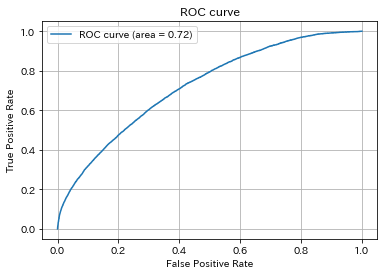

In [39]:
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

0.39679372273142355


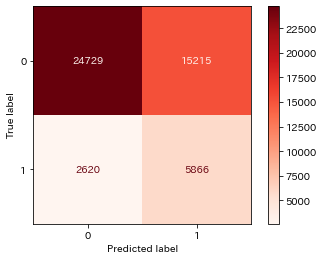

In [40]:
y_preds_bagging = np.where(y_preds_bagging < 0.5, 0, 1)

cm = confusion_matrix(y_test, y_preds_bagging)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

#F1スコアの計算
f1 = f1_score(y_test, y_preds_bagging)
print(f1)

In [ ]:
# https://upura.hatenablog.com/entry/2019/01/12/193000
# https://qiita.com/kunishou/items/2f25924509781b3463b6

#### オーバーサンプリング

In [81]:
#前処理
df = pd.read_csv('train.csv')
df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})

test = pd.read_csv('test.csv')
test.loan_status = 2

df = pd.concat([df, test], axis=0)

employment_list = {'0 years':0, '10 years':10, '1 year':1, '2 years':2, '3 years':3, '6 years':6,
                   '9 years':9, '7 years':7, '4 years':4, '5 years':5, '8 years':8}

df.term = df.term.replace({"3 years":3, "5 years":5})
df.employment_length = df.employment_length.replace(employment_list)
df.application_type = df.application_type.replace({"Individual":1, "Joint App":0}).astype(int)
#df = pd.get_dummies(df, columns=["grade", "purpose"])

train = df[:242150]
test = df[242150:]

# 目的変数と説明変数の生成
x = train.drop('loan_status', axis=1)
y = train['loan_status'].values.reshape(-1,1)

In [82]:
cat_cols = ['grade','purpose']

for c in x.columns:
    col_type = x[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        x[c] = x[c].astype('category')
        
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle = True)

In [83]:
# oversampling #この行で5分くらい必要
# SMOTEだと列数が16以上だとうまくいかないらしい
# SMOTENCはカテゴリ変数のままでOK

from imblearn.over_sampling import SMOTENC
smotenc = SMOTENC(categorical_features=[x.dtypes=='category'], random_state=42, k_neighbors=5)

X_resampled, y_resampled = smotenc.fit_resample(x_train,y_train)

# for validation
X_train2, X_valid, y_train2, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, shuffle = True)

X_train2.shape, y_train2.shape, X_valid.shape, y_valid.shape

((255760, 9), (255760,), (63940, 9), (63940,))

In [84]:
cat_cols = ['grade','purpose']

In [85]:
trains = lgb.Dataset(X_train2, y_train2)
valids = lgb.Dataset(X_valid, y_valid)

params = {'boosting_type': 'gbdt',
          'objective': 'binary', 
          'metric': 'auc', 
          'learning_rate': 0.01, 
#          'feature_pre_filter': False, 
          'bagging_freq': 1, 
          'num_leaves': 30, 
          'feature_fraction': 0.6, 
          'bagging_fraction': 0.9, 
          'min_child_samples': 10, 
          "num_boost_round":2000,
          "early_stopping_rounds": 100,
          'is_unbalance': True, 
}

model = lgb.train(params, trains, categorical_feature = cat_cols, valid_sets = [trains, valids], keep_training_booster = True, verbose_eval =300)

C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['grade', 'purpose']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 127972, number of negative: 127788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 255760, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500360 -> initscore=0.001439
[LightGBM] [Info] Start training from score 0.001439
Training until validation scores don't improve for 100 rounds


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[300]	training's auc: 0.89032	valid_1's auc: 0.890011
[600]	training's auc: 0.899544	valid_1's auc: 0.898338
[900]	training's auc: 0.903144	valid_1's auc: 0.901134
[1200]	training's auc: 0.90529	valid_1's auc: 0.902427
[1500]	training's auc: 0.907164	valid_1's auc: 0.903428
[1800]	training's auc: 0.908902	valid_1's auc: 0.90431
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.909931	valid_1's auc: 0.904789


In [86]:
y_pred = model.predict(x_test, num_iteration=model.best_iteration)
y_pred[:5]

# auc を計算する
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)

0.6920562284723949


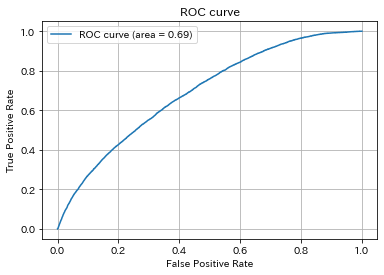

In [87]:
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

0.32037585274810143


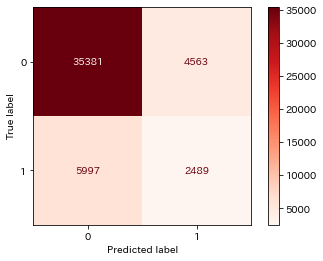

In [88]:
y_pred = np.where(y_pred < 0.5, 0, 1)

cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

#F1スコアの計算
f1 = f1_score(y_test, y_pred)
print(f1)

## テストデータの予測

In [264]:
# 目的変数と説明変数の生成
test_x = test.drop('loan_status', axis=1)
test_x.shape

(26900, 46)

#### 通常のモデルの場合

In [206]:
test_pred = model.predict(test_x, num_iteration = model.best_iteration)
print(len(test_pred))

26900


In [712]:
test_pred = np.where(test_pred < 0.5, 0, 1)
test_pred[:50]

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0])

In [713]:
# 提出ファイル
sub = test.copy()
sub['loan_status'] = test_pred
sub[['id','loan_status']].to_csv('sub17.csv', index=False, header = False)

#### ダウンサンプリングの場合

In [162]:
y_preds = []

for m in models:
    y_preds.append(m.predict(test_x, num_iteration=m.best_iteration))

y_preds_bagging = sum(y_preds)/len(y_preds)

In [163]:
y_preds_bagging = np.where(y_preds_bagging < 0.5, 0, 1)
y_preds_bagging[:50]

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0])

In [164]:
# 提出ファイル
sub = test.copy()
sub['loan_status'] = y_preds_bagging
sub[['id','loan_status']].to_csv('sub7.csv', index=False, header = False)

#### random averageの場合

In [600]:
test_preds = []

for i in range(3):
    test_preds.append(models[i].predict(test_x, num_iteration=models[i].best_iteration))

test_preds_bagging = sum(test_preds)/len(test_preds)

In [415]:
test_preds_bagging = np.where(test_preds_bagging < 0.5, 0, 1)
test_preds_bagging[:50]

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0])

In [601]:
# 提出ファイル
sub = test.copy()
sub['loan_status'] = test_preds_bagging
sub[['id','loan_status']].to_csv('raw30.csv', index=False, header = False)

#### ニューラルネットワークの場合

In [639]:
test_pred = model.predict(x_test)
print(len(test_pred))

841/841 [==============================] - 3s 3ms/step
26900


In [326]:
test_pred = np.where(test_pred < 0.5, 0, 1)
test_pred[:5]

array([[0],
       [1],
       [0],
       [0],
       [0]])

In [325]:
# 提出ファイル
sub = test.copy()
sub['loan_status'] = test_pred
sub[['id','loan_status']].to_csv('sub27.csv', index=False, header = False)

#### ニューラルネットワークの場合 ※ダウンサンプリング

In [ ]:
preds = []

for i in range(15):
    bagging(i)
    model.fit(X_train2, y_train2, epochs=1, batch_size=32, validation_data=(X_valid, y_valid))
    preds.append(model.predict(x_test))

y_preds_bagging = sum(preds)/len(preds)

In [ ]:
y_preds_bagging = np.where(y_preds_bagging < 0.5, 0, 1)
y_preds_bagging[:5]

In [ ]:
# 提出ファイル
sub = test.copy()
sub['loan_status'] = y_preds_bagging
sub[['id','loan_status']].to_csv('raw29.csv', index=False, header = False)

#### 出力の平均（調整）を出す場合

In [89]:
sub17 = pd.read_csv('sub17.csv', header=None, names=['id', 'pre'])
sub20 = pd.read_csv('sub20.csv', header=None, names=['id', 'pre'])

sub = pd.DataFrame(sub17)
sub20 = pd.DataFrame(sub20)

sub["pre2"] = sub20["pre"] 
sub["pre"] = (sub["pre"] + sub["pre2"]) / 2 

sub["pre"].value_counts()

0.0    15962
1.0    10032
0.5      906
Name: pre, dtype: int64

In [682]:
sub["pre"] = sub["pre"].replace(0.5,0).astype(int)
sub[['id','pre']].to_csv('sub24.csv', index=False, header = False)

In [90]:
# これまでのベストモデルとの1の数の違いを確認
sub17 = pd.read_csv('sub17.csv', header=None, names=['id', 'pre'])
sub31 = pd.read_csv('sub31.csv', header=None, names=['id', 'pre'])

sub17.pre.sum(), sub31.pre.sum()

(10576, 9771)

## (スタッキング（モデル構築から提出まで）)
・NNとLGBM→LGBMという突貫工事  
・それぞれモデルを保存しておけばコードは減らせたと反省

In [91]:
#NNでtrainの予想値を抽出

#前処理
df = pd.read_csv('train.csv')
df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})

test = pd.read_csv('test.csv')
test.loan_status = 2

df = pd.concat([df, test], axis=0)

employment_list = {'0 years':0, '10 years':10, '1 year':1, '2 years':2, '3 years':3, '6 years':6,
                   '9 years':9, '7 years':7, '4 years':4, '5 years':5, '8 years':8}

df.term = df.term.replace({"3 years":3, "5 years":5})
df.employment_length = df.employment_length.replace(employment_list)
df.application_type = df.application_type.replace({"Individual":1, "Joint App":0}).astype(int)
df = pd.get_dummies(df, columns=["grade", "purpose"])

In [92]:
#追加した特徴量
m_grade = df.grade_B1 + df.grade_B2 + df.grade_B3 + df.grade_B4 + df.grade_B5 + df.grade_C1 + df.grade_C2

df['Availability'] = df.loan_amnt * df.term * df.interest_rate / df.employment_length * m_grade
df['Availability'] = df['Availability'].fillna(0)
df['Availability'] = df['Availability'].replace(np.inf, 500000)

df['Assesment'] = df.interest_rate / df.credit_score * m_grade

In [93]:
# 目的変数と説明変数の生成
x = df.drop('loan_status', axis=1)
y = df['loan_status']

x.shape, y.shape

((269050, 46), (269050,))

In [94]:
from keras.models import Sequential
from sklearn.neural_network import MLPClassifier
from keras.layers import Dense, Activation, Dropout

In [95]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(x)
x = scaler.transform(x)

In [96]:
x_train = x[:242150]
y_train = y[:242150]

In [98]:
#ニューラルネットワーク
model = Sequential()
model.add(Dense(30, input_dim=46))    # 入力層46ノード, 隠れ層に20ノード, 全結合
model.add(Activation("relu"))
model.add(Dropout(rate=0.4))

model.add(Dense(30))    # 隠れ層に100ノード, 全結合
model.add(Activation("relu"))
model.add(Dropout(rate=0.4))

model.add(Dense(1)) # 出力層1ノード,全結合
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy",   # 誤差関数
              optimizer="adam", # 最適化手法
              metrics=['accuracy'])

In [99]:
from imblearn.under_sampling import RandomUnderSampler

def bagging(seed):
    sampler = RandomUnderSampler(random_state = seed)
    X_resampled, y_resampled = sampler.fit_resample(x_train, y_train)
    X_train2, X_valid, y_train2, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, shuffle = True)
    model.fit(X_train2, y_train2, epochs=1, batch_size=32, validation_data=(X_valid, y_valid))

In [100]:
preds = []

for i in range(10):
    bagging(i)
    
    y_pred = model.predict(x_train)
    preds.append(y_pred)

    print(i, y_pred)
    
y_preds_bagging = sum(preds)/len(preds)

7568/7568 [==============================] - 9s 1ms/step
0 [[0.19875306]
 [0.43368563]
 [0.4978068 ]
 ...
 [0.15532783]
 [0.5031933 ]
 [0.5310296 ]]
7568/7568 [==============================] - 8s 1ms/step
1 [[0.17526788]
 [0.38930193]
 [0.48852095]
 ...
 [0.17610992]
 [0.5013021 ]
 [0.51063794]]
7568/7568 [==============================] - 8s 1ms/step
2 [[0.22163671]
 [0.39381102]
 [0.48642224]
 ...
 [0.21610515]
 [0.49855727]
 [0.5166911 ]]
7568/7568 [==============================] - 9s 1ms/step
3 [[0.15922414]
 [0.41303134]
 [0.48760328]
 ...
 [0.12559275]
 [0.50179696]
 [0.5332356 ]]
7568/7568 [==============================] - 8s 1ms/step
4 [[0.19257519]
 [0.4380786 ]
 [0.48587757]
 ...
 [0.2253622 ]
 [0.4977951 ]
 [0.5041319 ]]
7568/7568 [==============================] - 9s 1ms/step
5 [[0.18617265]
 [0.43862012]
 [0.4680171 ]
 ...
 [0.17493463]
 [0.4959184 ]
 [0.5088503 ]]
7568/7568 [==============================] - 9s 1ms/step
6 [[0.17602071]
 [0.423235  ]
 [0.5115758 ]
 ...


In [660]:
raw29 = df[:242150].copy()
raw29["raw29"] = y_preds_bagging
raw29[["id","raw29"]].to_csv('raw29.csv', index=False)

In [101]:
#層化k分割でtrainの予測値を抽出

#前処理
df = pd.read_csv('train.csv')
df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})

test = pd.read_csv('test.csv')
test.loan_status = 10

df = pd.concat([df, test], axis=0)

employment_list = {'0 years':0, '10 years':10, '1 year':1, '2 years':2, '3 years':3, '6 years':6,
                   '9 years':9, '7 years':7, '4 years':4, '5 years':5, '8 years':8}

df.term = df.term.replace({"3 years":3, "5 years":5})
df.employment_length = df.employment_length.replace(employment_list)
df.application_type = df.application_type.replace({"Individual":1, "Joint App":0}).astype(int)
df = pd.get_dummies(df, columns=["grade", "purpose"])

In [102]:
#追加した特徴量
m_grade = df.grade_B1 + df.grade_B2 + df.grade_B3 + df.grade_B4 + df.grade_B5 + df.grade_C1 + df.grade_C2

df['Availability'] = df.loan_amnt * df.term * df.interest_rate / df.employment_length * m_grade
df['Assesment'] = df.interest_rate / df.credit_score * m_grade

In [103]:
# 目的変数と説明変数の生成
train = df[:242150]
test = df[242150:]

x = train.drop('loan_status', axis=1)
y = train['loan_status']

x.shape, y.shape

((242150, 46), (242150,))

In [104]:
#学習・テストデータへの分割
models = []
valid_scores = []

from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in kf.split(x, y):
            
    x_train = x.iloc[train_index]
    y_train = y.iloc[train_index]
    x_test = x.iloc[test_index]
    y_test = y.iloc[test_index]
    
    trains = lgb.Dataset(x_train, y_train)
    valids = lgb.Dataset(x_test, y_test)

    params = {
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': -1,
    'subsample_freq': 1,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round":20000,
    "early_stopping_rounds": 100,
    'num_leaves': 30,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.9,
    'is_unbalance': True,
    }

    model = lgb.train(params, trains, valid_sets = [trains, valids], keep_training_booster = True, verbose_eval =300)

    y_pred = model.predict(x_test, num_iteration=model.best_iteration)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)

    models.append(model)
    valid_scores.append(auc)

C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.72306	valid_1's auc: 0.714366
[600]	training's auc: 0.731131	valid_1's auc: 0.716679
[900]	training's auc: 0.738156	valid_1's auc: 0.717271
[1200]	training's auc: 0.744781	valid_1's auc: 0.717683
[1500]	training's auc: 0.750968	valid_1's auc: 0.717905
Early stopping, best iteration is:
[1509]	training's auc: 0.751137	valid_1's auc: 0.717916


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.721562	valid_1's auc: 0.717829
[600]	training's auc: 0.729759	valid_1's auc: 0.720233
[900]	training's auc: 0.736982	valid_1's auc: 0.720646
[1200]	training's auc: 0.743873	valid_1's auc: 0.720784
Early stopping, best iteration is:
[1168]	training's auc: 0.743167	valid_1's auc: 0.720804


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.723503	valid_1's auc: 0.713762
[600]	training's auc: 0.731457	valid_1's auc: 0.715859
[900]	training's auc: 0.738253	valid_1's auc: 0.716419
[1200]	training's auc: 0.744704	valid_1's auc: 0.716653
[1500]	training's auc: 0.750779	valid_1's auc: 0.716735
Early stopping, best iteration is:
[1555]	training's auc: 0.751838	valid_1's auc: 0.716773


In [105]:
valid_scores

[0.7179157677815048, 0.7208038489219646, 0.7167725707967945]

In [106]:
y_preds = []

for i in range(3):
    y_preds.append(models[i].predict(x, num_iteration=models[i].best_iteration))

y_preds_bagging = sum(y_preds)/len(y_preds)

In [672]:
raw30 = train.copy()
raw30["raw30"] = y_preds_bagging
raw30[["id","raw30"]].to_csv('raw30.csv', index=False)

In [673]:
#2つの予測値をLGBMでさらに学習
raw29 = pd.read_csv('raw29.csv')
raw30 = pd.read_csv('raw30.csv')

mix = raw29.copy()
mix["raw30"] = raw30.iloc[:,1]

In [675]:
#前処理
df = pd.read_csv('train.csv')
df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})

df["pred1"] = mix.iloc[:,1]
df["pred2"] = mix.iloc[:,2]

In [678]:
# 目的変数と説明変数の生成
x = df[["pred1","pred2"]]
y = df['loan_status']

x.shape, y.shape

((242150, 2), (242150,))

In [679]:
#学習・テストデータへの分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle = True)

In [680]:
#モデル構築
trains = lgb.Dataset(x_train, y_train)
valids = lgb.Dataset(x_test, y_test)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': -1,
    'subsample_freq': 1,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round":20000,
    "early_stopping_rounds": 100,
    'num_leaves': 30,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.9,
    'is_unbalance': True,
}

model = lgb.train(params, trains, valid_sets = [trains, valids], keep_training_booster = True, verbose_eval =300)

C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.733141	valid_1's auc: 0.734162
[600]	training's auc: 0.736601	valid_1's auc: 0.736567
[900]	training's auc: 0.739468	valid_1's auc: 0.738797
[1200]	training's auc: 0.741666	valid_1's auc: 0.740548
[1500]	training's auc: 0.743345	valid_1's auc: 0.741899
[1800]	training's auc: 0.744642	valid_1's auc: 0.743032
[2100]	training's auc: 0.745677	valid_1's auc: 0.743935
[2400]	training's auc: 0.746525	valid_1's auc: 0.744711
[2700]	training's auc: 0.747233	valid_1's auc: 0.745409
[3000]	training's auc: 0.747829	valid_1's auc: 0.745969
[3300]	training's auc: 0.748341	valid_1's auc: 0.746475
[3600]	training's auc: 0.748763	valid_1's auc: 0.746921
[3900]	training's auc: 0.749131	valid_1's auc: 0.747305
[4200]	training's auc: 0.749449	valid_1's auc: 0.747616
[4500]	training's auc: 0.749724	valid_1's auc: 0.74789
[4800]	training's auc: 0.749964	valid_1's auc: 0.74816
[5100]	training's auc: 0.750167	valid_1's auc: 

In [681]:
#予測値の計算
y_pred = model.predict(x_test, num_iteration=model.best_iteration)
y_pred[:5]

array([0.47575341, 0.56681531, 0.65484761, 0.49855455, 0.26758497])

In [682]:
#AUCの計算
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)

0.7497352025808085


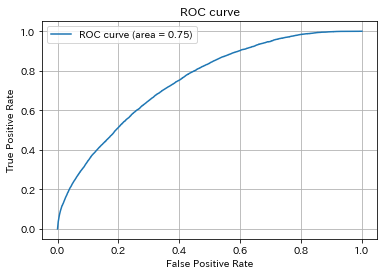

In [683]:
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [684]:
y_pred = np.where(y_pred < 0.5, 0, 1)

0.4174799905440546


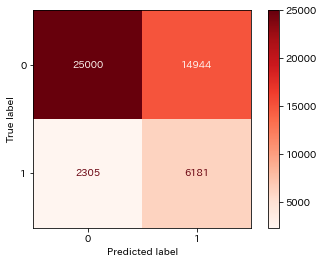

In [685]:
# 混同行列を表示
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

#F1スコアの計算
f1 = f1_score(y_test, y_pred)
print(f1)

In [686]:
#特徴量の寄与率
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=x_train.columns, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
display(importance[:20])

,importance
pred2,1.955978e+06
pred1,1.372034e+06


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

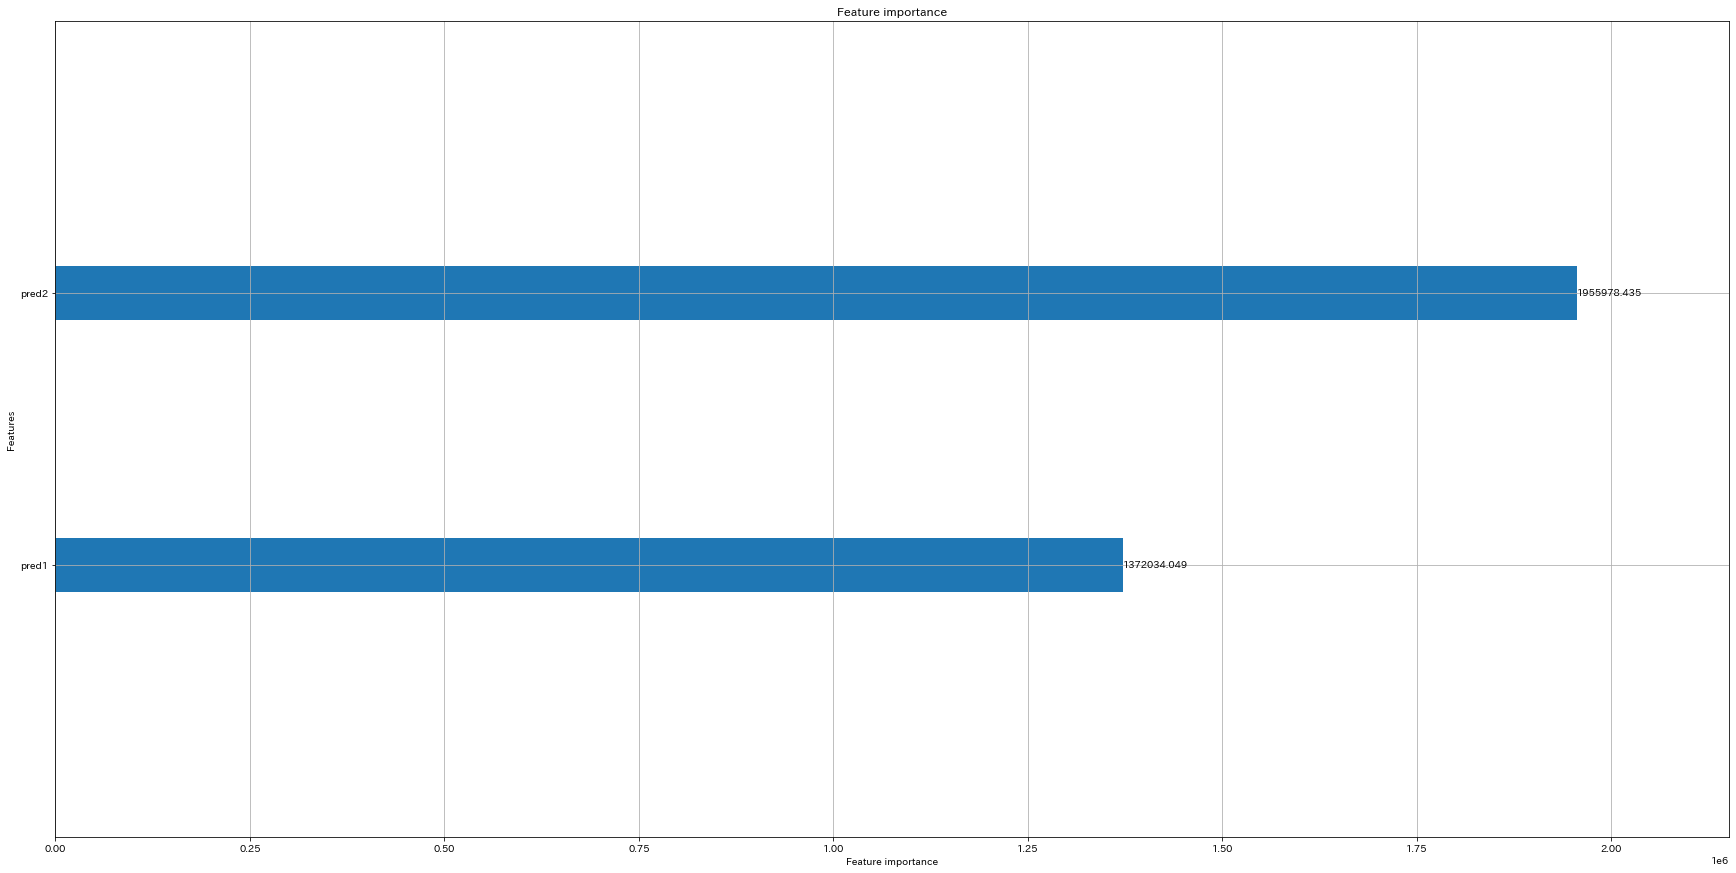

In [687]:
#特徴量重要度の可視化
lgb.plot_importance(model, figsize=(30,15), max_num_features=20, importance_type='gain')

In [107]:
#NNでtestの予想値を抽出

#前処理
df = pd.read_csv('train.csv')
df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})

test = pd.read_csv('test.csv')
test.loan_status = 2

df = pd.concat([df, test], axis=0)

employment_list = {'0 years':0, '10 years':10, '1 year':1, '2 years':2, '3 years':3, '6 years':6,
                   '9 years':9, '7 years':7, '4 years':4, '5 years':5, '8 years':8}

df.term = df.term.replace({"3 years":3, "5 years":5})
df.employment_length = df.employment_length.replace(employment_list)
df.application_type = df.application_type.replace({"Individual":1, "Joint App":0}).astype(int)
df = pd.get_dummies(df, columns=["grade", "purpose"])

In [108]:
#追加した特徴量
m_grade = df.grade_B1 + df.grade_B2 + df.grade_B3 + df.grade_B4 + df.grade_B5 + df.grade_C1 + df.grade_C2

df['Availability'] = df.loan_amnt * df.term * df.interest_rate / df.employment_length * m_grade
df['Availability'] = df['Availability'].fillna(0)
df['Availability'] = df['Availability'].replace(np.inf, 500000)

df['Assesment'] = df.interest_rate / df.credit_score * m_grade

In [109]:
# 目的変数と説明変数の生成
x = df.drop('loan_status', axis=1)
y = df['loan_status']

x.shape, y.shape

((269050, 46), (269050,))

In [110]:
from keras.models import Sequential
from sklearn.neural_network import MLPClassifier
from keras.layers import Dense, Activation, Dropout

In [111]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(x)
x = scaler.transform(x)

In [112]:
x_train = x[:242150]
x_test = x[242150:]

y_train = y[:242150]
y_test = y[242150:]

In [113]:
#ニューラルネットワーク
model = Sequential()
model.add(Dense(30, input_dim=46))    # 入力層46ノード, 隠れ層に20ノード, 全結合
model.add(Activation("relu"))
model.add(Dropout(rate=0.4))

model.add(Dense(30))    # 隠れ層に100ノード, 全結合
model.add(Activation("relu"))
model.add(Dropout(rate=0.4))

model.add(Dense(1)) # 出力層1ノード,全結合
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy",   # 誤差関数
              optimizer="adam", # 最適化手法
              metrics=['accuracy'])

In [114]:
def bagging(seed):
    sampler = RandomUnderSampler(random_state = seed)
    X_resampled, y_resampled = sampler.fit_resample(x_train, y_train)
    X_train2, X_valid, y_train2, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, shuffle = True)
    model.fit(X_train2, y_train2, epochs=1, batch_size=32, validation_data=(X_valid, y_valid))

In [115]:
preds = []

for i in range(15):
    bagging(i)
        
    y_pred = model.predict(x_test)
    preds.append(y_pred)

    print(i, y_pred)
    
y_preds_bagging = sum(preds)/len(preds)

841/841 [==============================] - 1s 1ms/step
0 [[0.44122985]
 [0.63824487]
 [0.16658463]
 ...
 [0.33098075]
 [0.42226672]
 [0.15333647]]
841/841 [==============================] - 1s 1ms/step
1 [[0.45323187]
 [0.6347481 ]
 [0.21927021]
 ...
 [0.37458575]
 [0.40841895]
 [0.17717087]]
841/841 [==============================] - 1s 1ms/step
2 [[0.4420643 ]
 [0.59192926]
 [0.17182544]
 ...
 [0.34043396]
 [0.36555523]
 [0.15751928]]
841/841 [==============================] - 1s 1ms/step
3 [[0.43892005]
 [0.6004495 ]
 [0.1974849 ]
 ...
 [0.33088982]
 [0.3518371 ]
 [0.1669234 ]]
841/841 [==============================] - 1s 1ms/step
4 [[0.41691005]
 [0.59347016]
 [0.18373191]
 ...
 [0.32368776]
 [0.384023  ]
 [0.14958905]]
841/841 [==============================] - 1s 1ms/step
5 [[0.45844173]
 [0.6112975 ]
 [0.12298499]
 ...
 [0.28921044]
 [0.3492136 ]
 [0.10072347]]
841/841 [==============================] - 1s 1ms/step
6 [[0.44185057]
 [0.5892794 ]
 [0.17981647]
 ...
 [0.32429555]


In [718]:
raw29 = df[242150:].copy()
raw29["test_raw29"] = y_preds_bagging
raw29[["id","test_raw29"]].to_csv('test_raw29.csv', index=False)

In [719]:
#層化k分割でtestの予測値を抽出

#前処理
df = pd.read_csv('train.csv')
df.loan_status = df.loan_status.replace({"FullyPaid":0, "ChargedOff":1})

test = pd.read_csv('test.csv')
test.loan_status = 10

df = pd.concat([df, test], axis=0)

employment_list = {'0 years':0, '10 years':10, '1 year':1, '2 years':2, '3 years':3, '6 years':6,
                   '9 years':9, '7 years':7, '4 years':4, '5 years':5, '8 years':8}

df.term = df.term.replace({"3 years":3, "5 years":5})
df.employment_length = df.employment_length.replace(employment_list)
df.application_type = df.application_type.replace({"Individual":1, "Joint App":0}).astype(int)
df = pd.get_dummies(df, columns=["grade", "purpose"])

In [720]:
#追加した特徴量
m_grade = df.grade_B1 + df.grade_B2 + df.grade_B3 + df.grade_B4 + df.grade_B5 + df.grade_C1 + df.grade_C2

df['Availability'] = df.loan_amnt * df.term * df.interest_rate / df.employment_length * m_grade
df['Assesment'] = df.interest_rate / df.credit_score * m_grade

In [721]:
# 目的変数と説明変数の生成
train = df[:242150]
test = df[242150:]

x = train.drop('loan_status', axis=1)
y = train['loan_status']

x.shape, y.shape

((242150, 46), (242150,))

In [722]:
test_x = test.drop('loan_status', axis=1)
test_x.shape

(26900, 46)

In [723]:
#学習・テストデータへの分割
models = []
valid_scores = []

from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in kf.split(x, y):
            
    x_train = x.iloc[train_index]
    y_train = y.iloc[train_index]
    x_test = x.iloc[test_index]
    y_test = y.iloc[test_index]
    
    trains = lgb.Dataset(x_train, y_train)
    valids = lgb.Dataset(x_test, y_test)

    params = {
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': -1,
    'subsample_freq': 1,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round":20000,
    "early_stopping_rounds": 100,
    'num_leaves': 30,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.9,
    'is_unbalance': True,
    }

    model = lgb.train(params, trains, valid_sets = [trains, valids], keep_training_booster = True, verbose_eval =300)

    y_pred = model.predict(x_test, num_iteration=model.best_iteration)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)

    models.append(model)
    valid_scores.append(auc)

C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.72306	valid_1's auc: 0.714366
[600]	training's auc: 0.731131	valid_1's auc: 0.716679
[900]	training's auc: 0.738156	valid_1's auc: 0.717271
[1200]	training's auc: 0.744781	valid_1's auc: 0.717683
[1500]	training's auc: 0.750968	valid_1's auc: 0.717905
Early stopping, best iteration is:
[1509]	training's auc: 0.751137	valid_1's auc: 0.717916


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.721562	valid_1's auc: 0.717829
[600]	training's auc: 0.729759	valid_1's auc: 0.720233
[900]	training's auc: 0.736982	valid_1's auc: 0.720646
[1200]	training's auc: 0.743873	valid_1's auc: 0.720784
Early stopping, best iteration is:
[1168]	training's auc: 0.743167	valid_1's auc: 0.720804


C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kokam\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.723503	valid_1's auc: 0.713762
[600]	training's auc: 0.731457	valid_1's auc: 0.715859
[900]	training's auc: 0.738253	valid_1's auc: 0.716419
[1200]	training's auc: 0.744704	valid_1's auc: 0.716653
[1500]	training's auc: 0.750779	valid_1's auc: 0.716735
Early stopping, best iteration is:
[1555]	training's auc: 0.751838	valid_1's auc: 0.716773


In [724]:
valid_scores

[0.7179157677815048, 0.7208038489219646, 0.7167725707967945]

In [725]:
y_preds = []

for i in range(3):
    y_preds.append(models[i].predict(test_x, num_iteration=models[i].best_iteration))

y_preds_bagging = sum(y_preds)/len(y_preds)

In [727]:
raw30 = test.copy()
raw30["test_raw30"] = y_preds_bagging
raw30[["id","test_raw30"]].to_csv('test_raw30.csv', index=False)

In [728]:
#final_modelで予測の抽出
model = pickle.load(open('final_model.pkl', 'rb'))

In [732]:
#2つの予測値をLGBMでさらに学習
test_raw29 = pd.read_csv('test_raw29.csv')
test_raw30 = pd.read_csv('test_raw30.csv')

mix = test_raw29.copy()
mix["raw30"] = test_raw30.iloc[:,1]

In [733]:
x = mix.iloc[:,1:]
x

,test_raw29,raw30
0,0.458036,0.404890
1,0.624519,0.693054
2,0.177896,0.162050
3,0.066677,0.032509
4,0.333848,0.269437
...,...,...
26895,0.366217,0.279230
26896,0.067344,0.079024
26897,0.305999,0.235852
26898,0.375337,0.311826


In [737]:
#予測値の計算
y_pred = model.predict(x, num_iteration=model.best_iteration)
y_pred = np.where(y_pred < 0.5, 0, 1)
y_pred[:5]

array([0, 1, 0, 0, 0])

In [738]:
# 提出ファイル
test = pd.read_csv('test.csv')

sub = test.copy()
sub['loan_status'] = y_pred
sub[['id','loan_status']].to_csv('sub31.csv', index=False, header = False)

## 振り返り
・特徴量エンジニアリングにて、一般論として理解できるような内容を盛り込んで精度が上げられたことは成果として考えられそう

・ランダムシードアベレージやダウンサンプリング、スタッキングを行う際、  
検証テーマ内でも、検証テーマ間でも、学習データと検証データを明確に切り分け、リークを防ぐことかつ評価基準が変わらないように徹底をすべきだった  
・また、閾値の最適解が0.5以外であることを見逃していたが、検証は細かなレベルで行い、かつログを残すべきだった  
(閾値を0.1単位で検証をして、0.5が最適であると思い込んだが、実際には0.53が最適だった)